In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [2]:
random_state = 123*987*4-1
models_to_average = 50

In [3]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp1.0.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp1.0.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp1.0.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp1.0.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [4]:
len(synt_data_cerebras.columns)

18

In [5]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [6]:
cols = real_dataset.columns

In [7]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [8]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [9]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [10]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [11]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [12]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [13]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [14]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [15]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [16]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [17]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [18]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [19]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [20]:
print(real_dataset.isna().sum().sum())

0


In [21]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

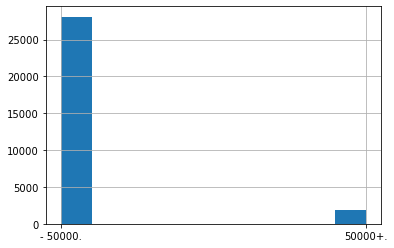

In [22]:
real_dataset['target'].hist()

In [23]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


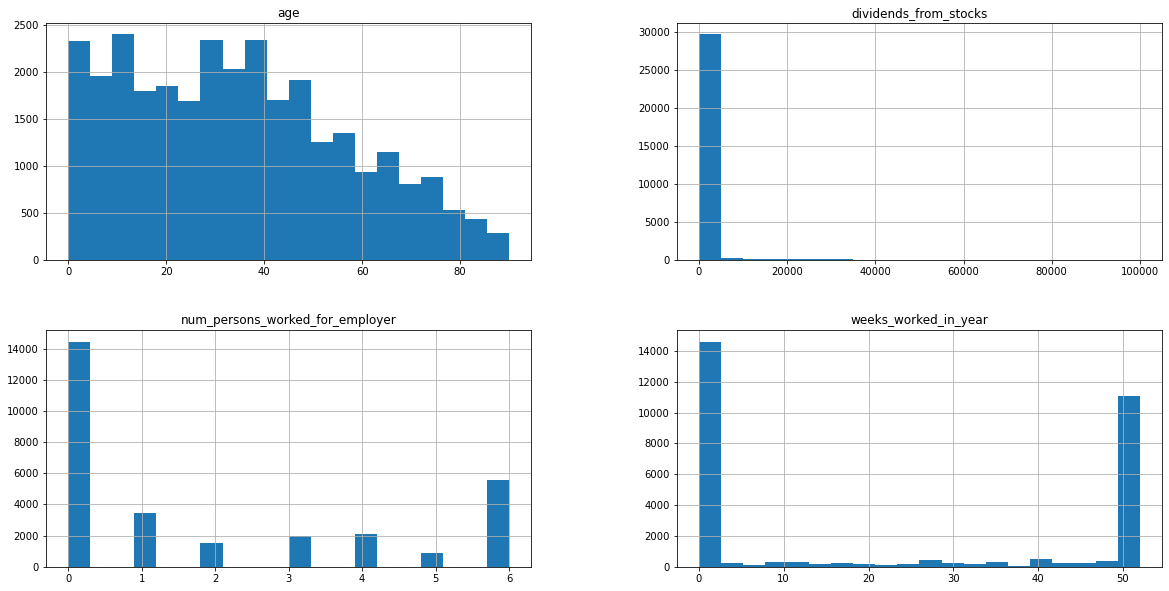

In [24]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

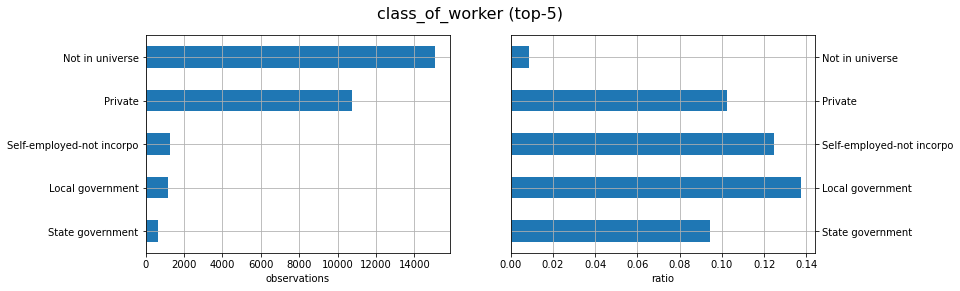

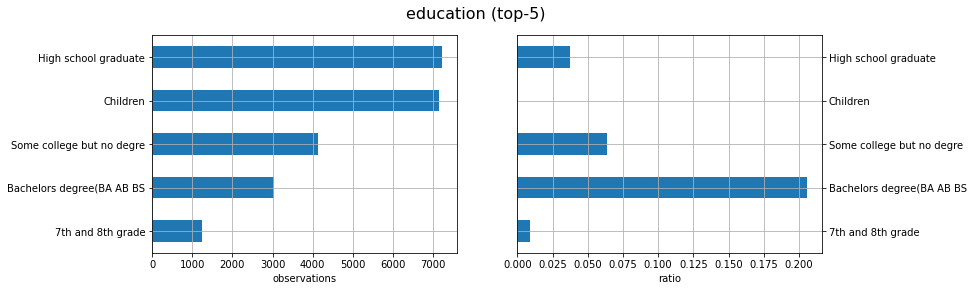

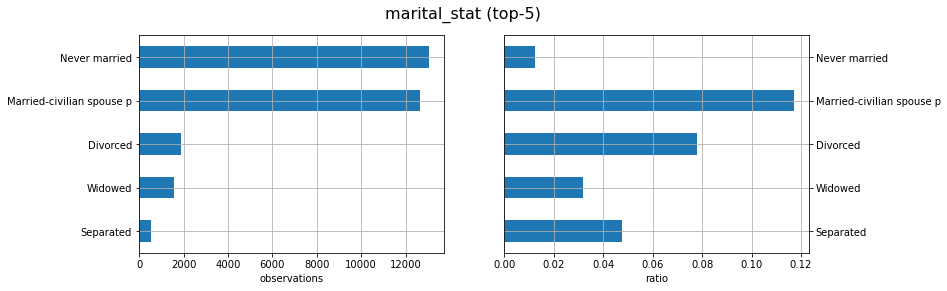

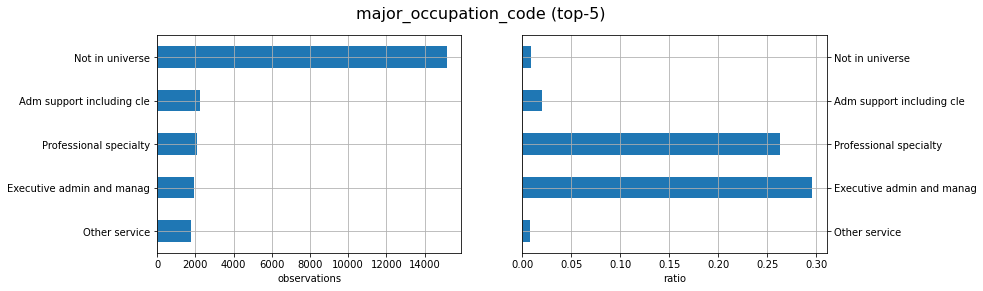

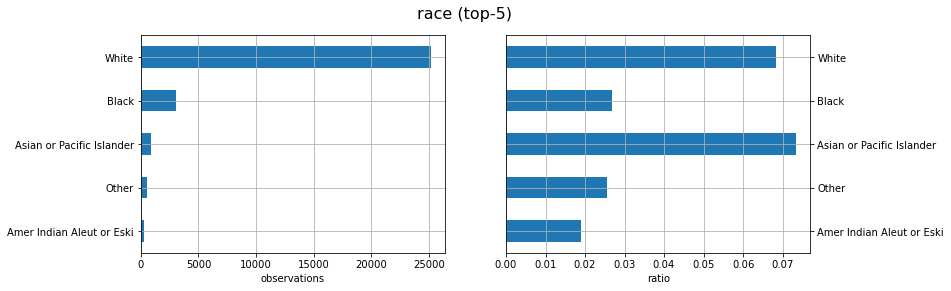

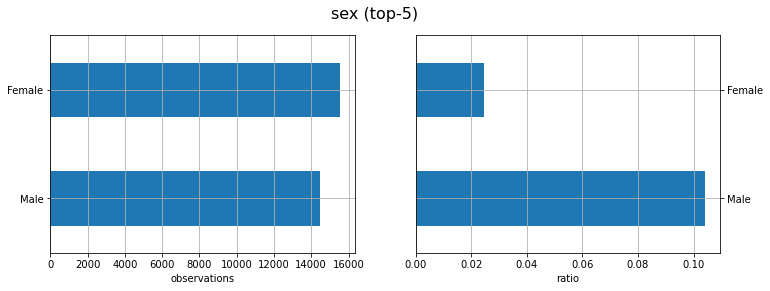

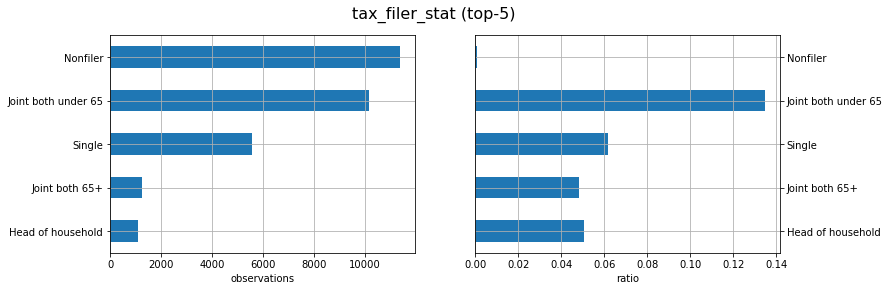

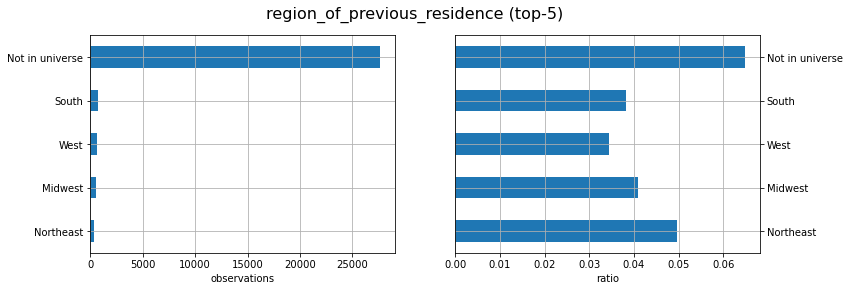

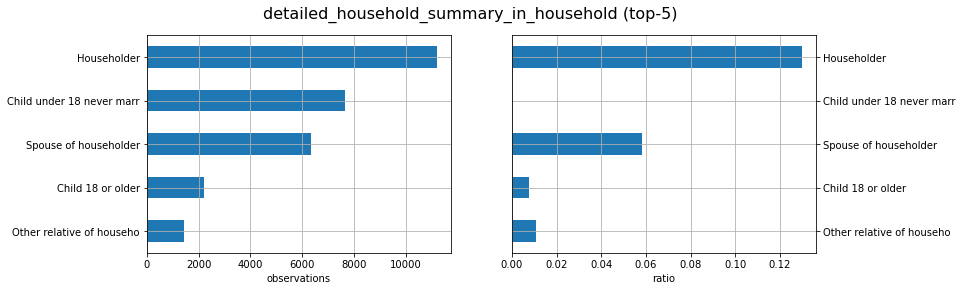

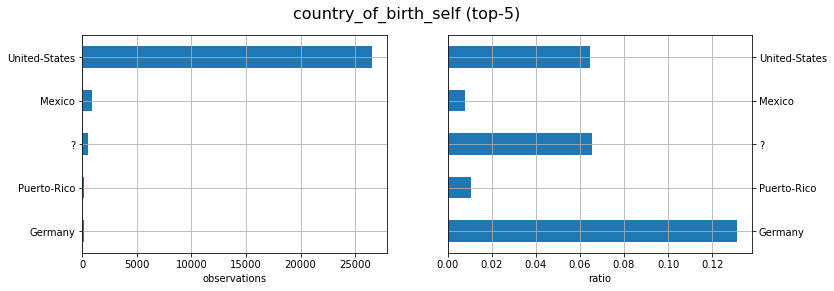

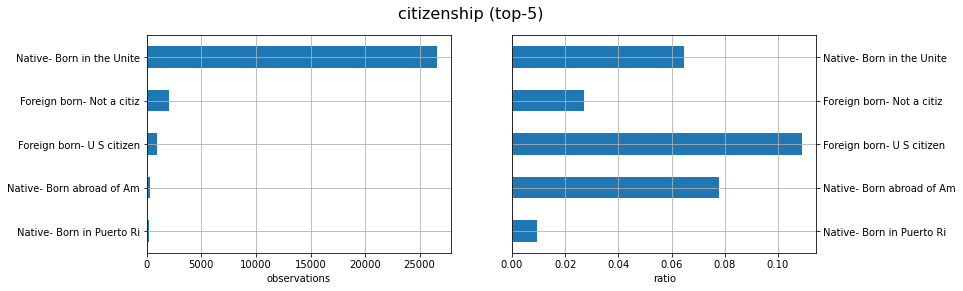

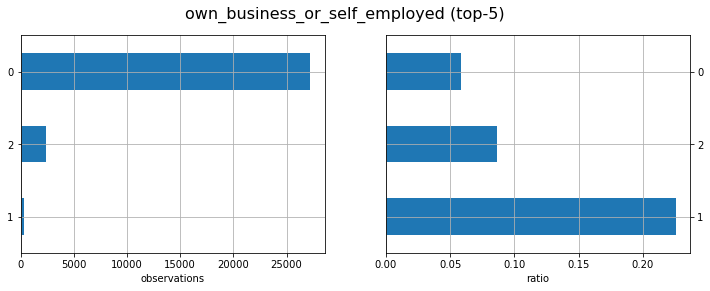

In [25]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [26]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      36.276667             195.321100                         2.158567   
std       29.039130            4415.994559                         4.449489   
min        0.000000               0.000000                         0.000000   
25%       20.000000               0.000000                         0.000000   
50%       35.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max     3500.000000          600063.000000                       500.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.178400             24.577633  
std                         1.359817             24.403582  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             16.000000  
75%                         0.000000             52.000000  
max                       200.000000             60.000000

In [27]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

0
age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [28]:
synt_data_distilgpt2['target'].unique()

array(['50000+.', '- 50000.'], dtype=object)

<AxesSubplot:>

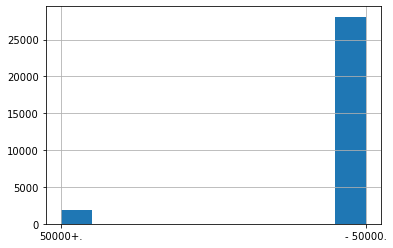

In [29]:
synt_data_distilgpt2['target'].hist()

In [30]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


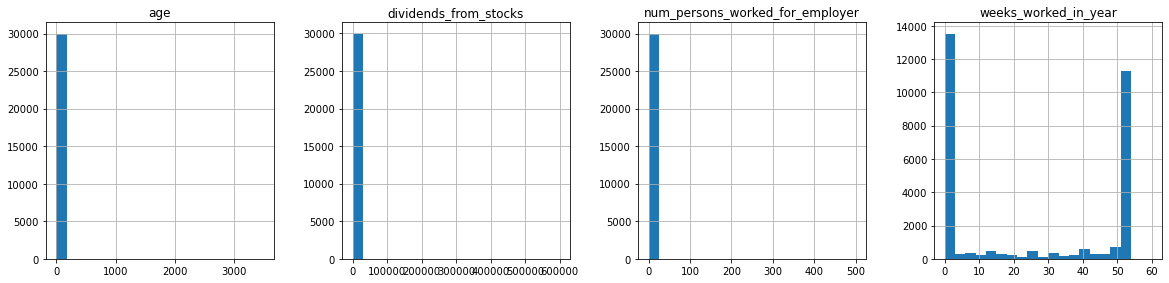

In [31]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

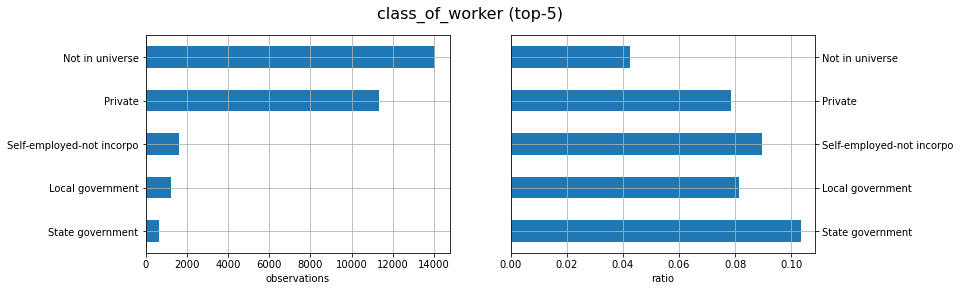

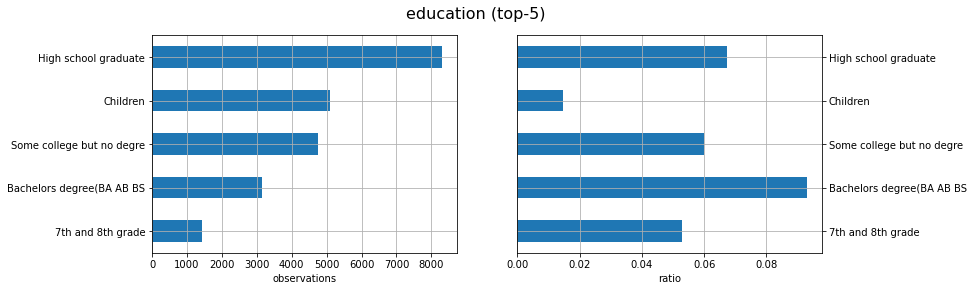

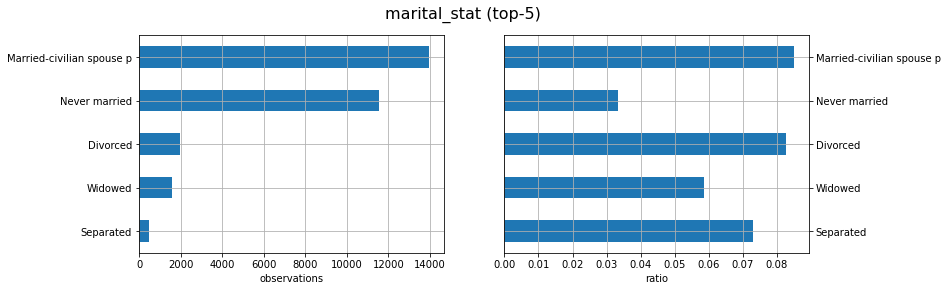

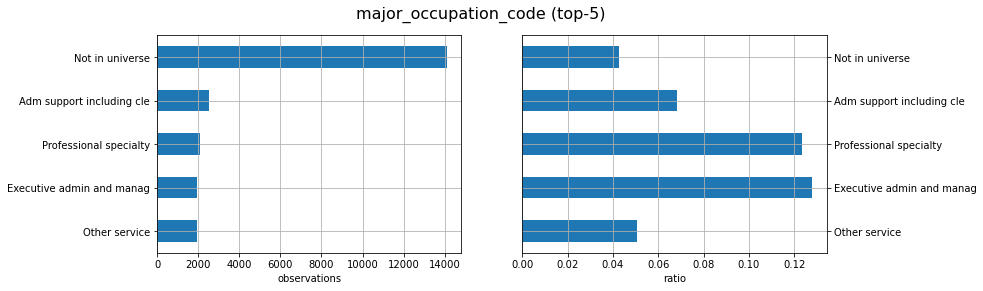

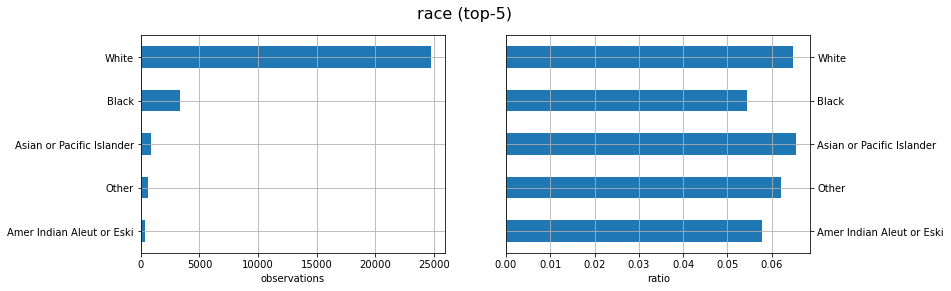

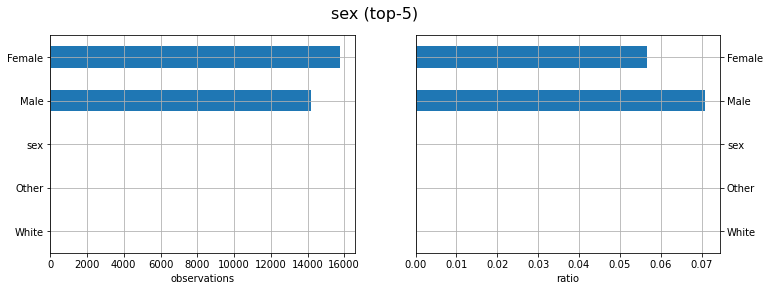

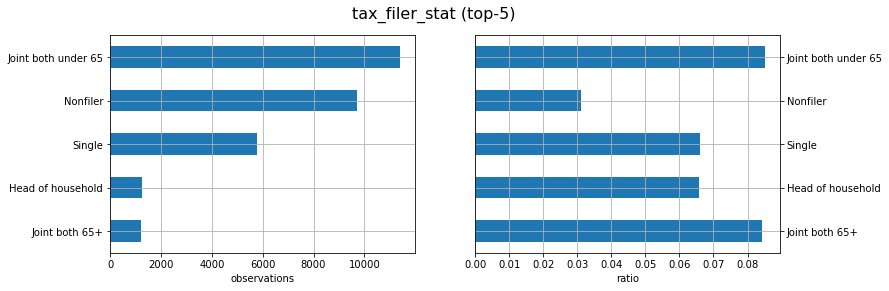

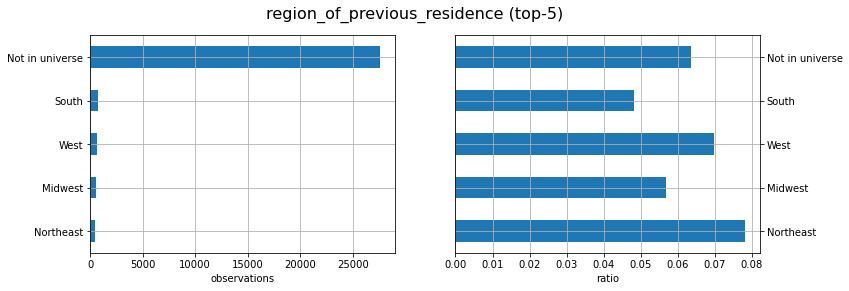

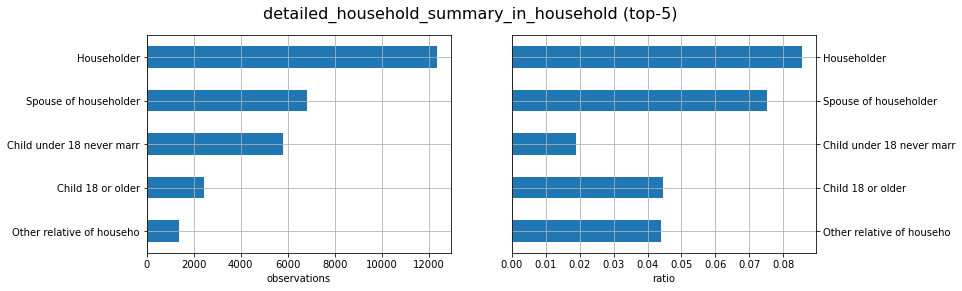

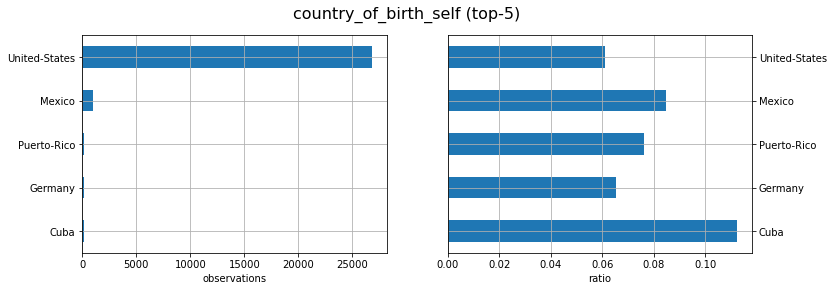

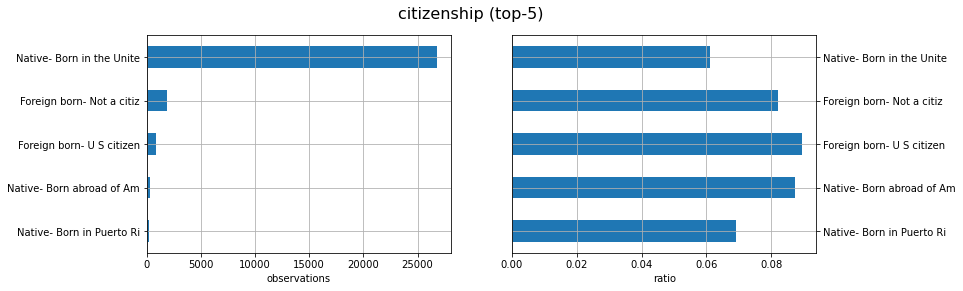

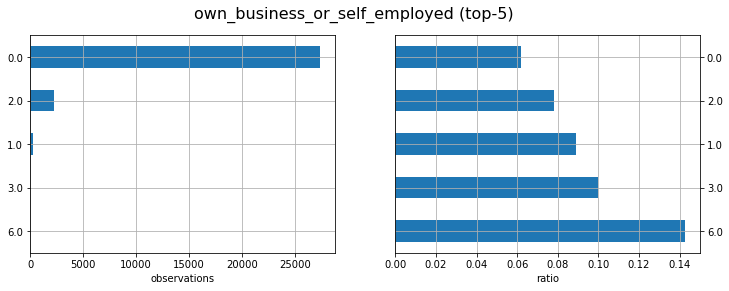

In [32]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [33]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      32.750467             160.988500                         2.014467   
std       21.257933            2478.391399                         2.399274   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       31.000000               0.000000                         1.000000   
75%       47.000000               0.000000                         4.000000   
max       90.000000          125000.000000                        14.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.162833             23.320733  
std                         0.561364             24.408946  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             10.000000  
75%                         0.000000             52.000000  
max                        30.000000             52.000000

In [34]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [35]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

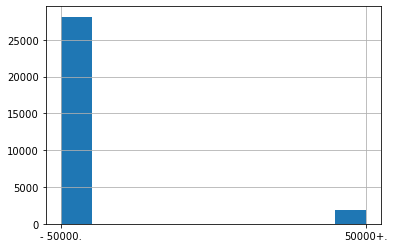

In [36]:
synt_data_gpt2xl['target'].hist()

In [37]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.23% and 93.77%


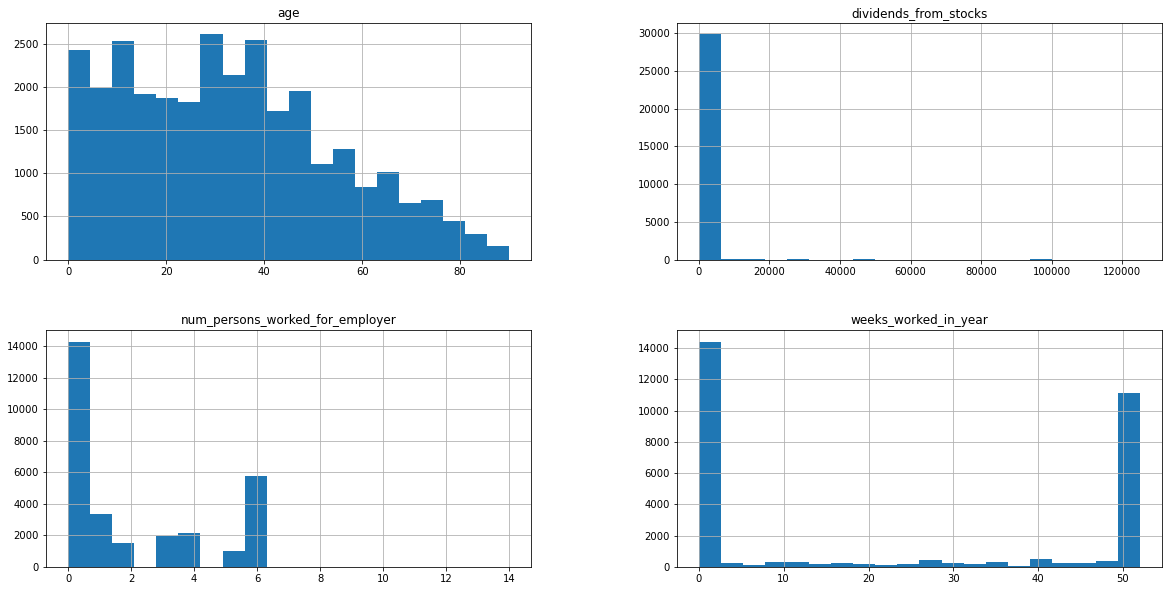

In [38]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

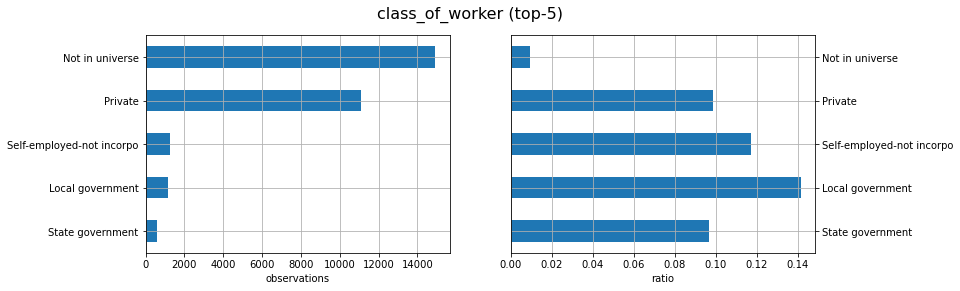

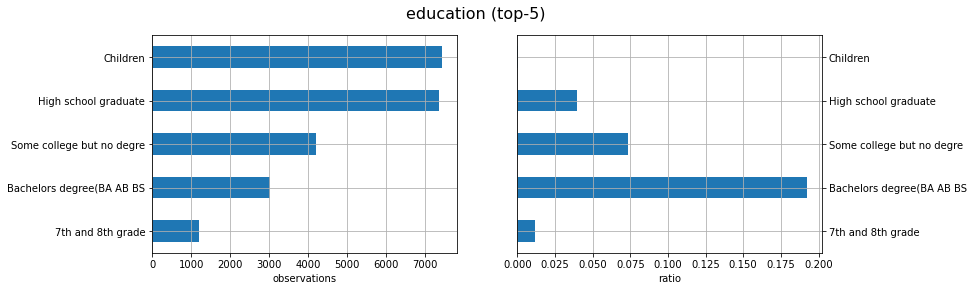

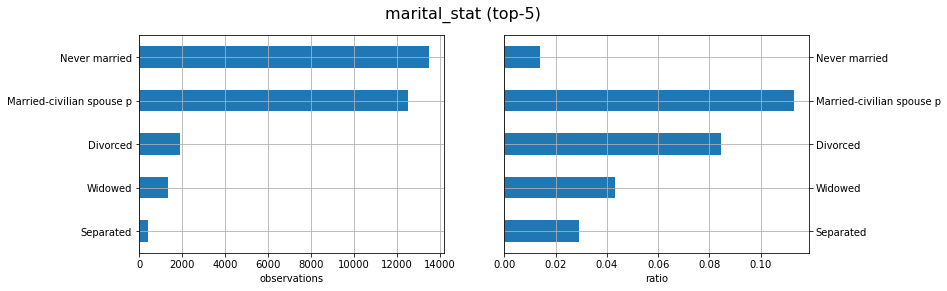

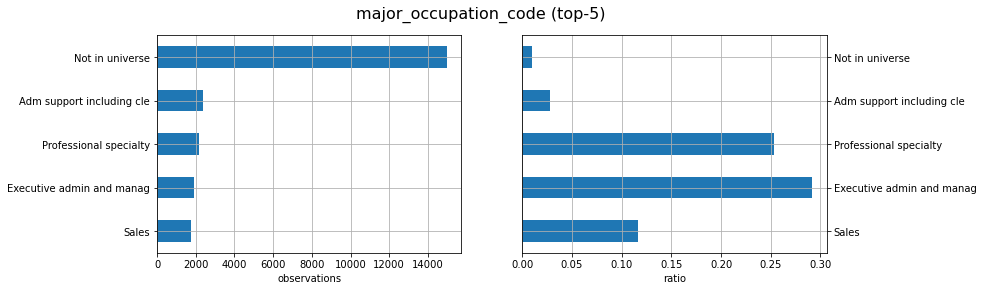

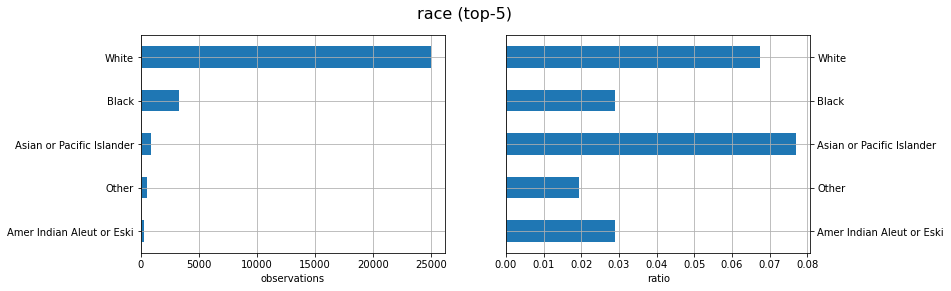

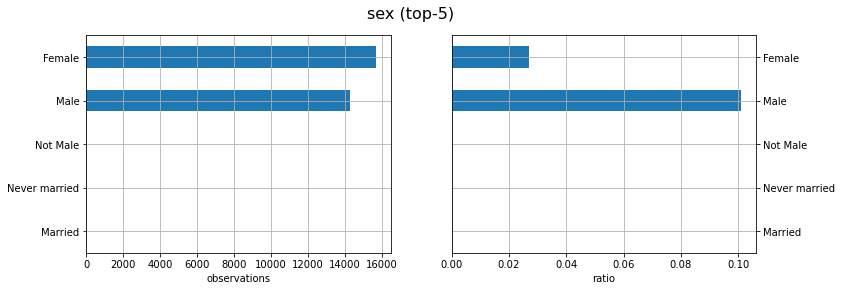

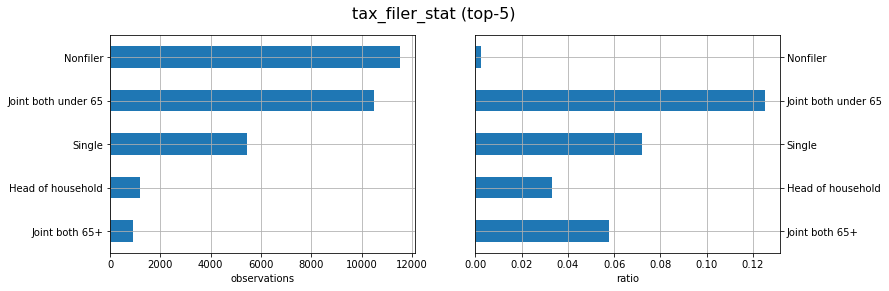

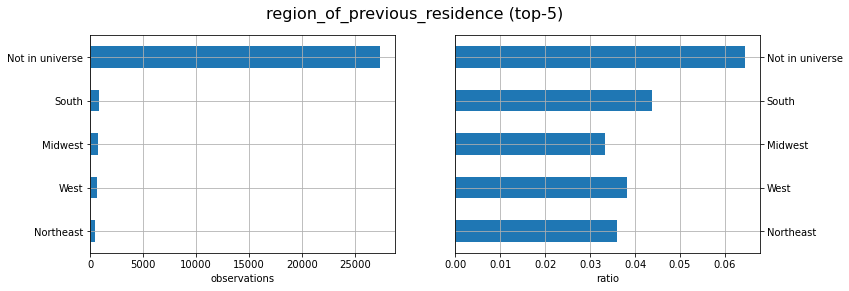

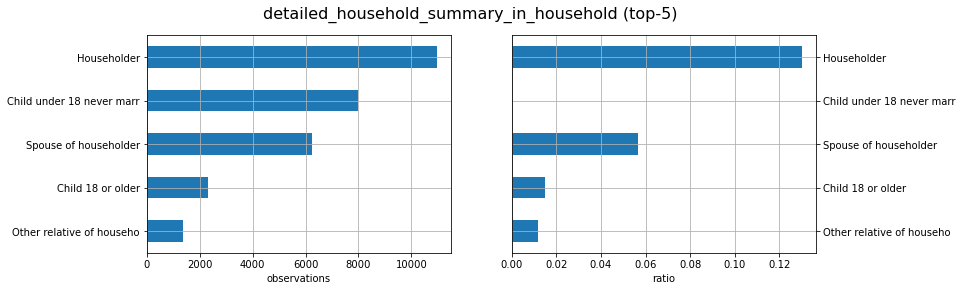

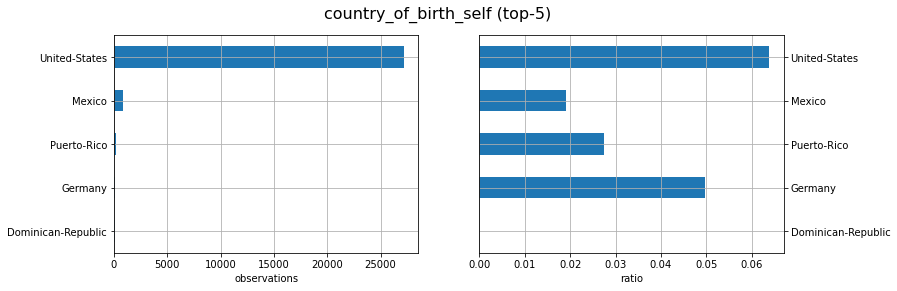

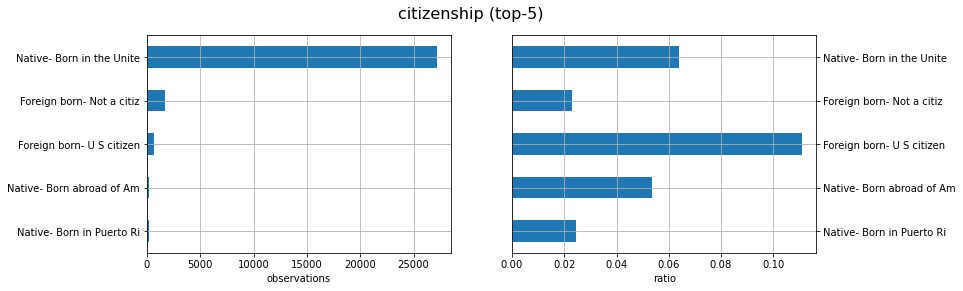

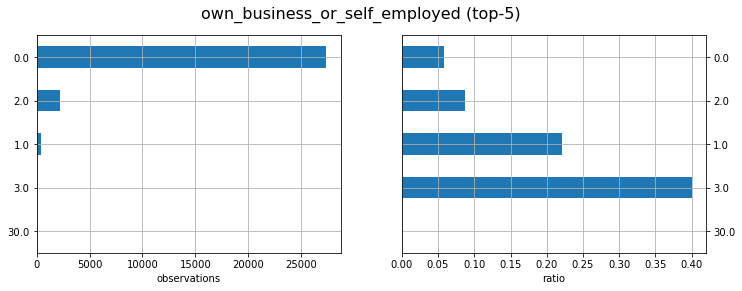

In [39]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [40]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      33.007800             146.228667                         2.007533   
std       21.558956            2030.594577                         2.414140   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       31.000000               0.000000                         1.000000   
75%       47.000000               0.000000                         4.000000   
max       90.000000           99999.000000                        50.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.157067             23.541433  
std                         0.525299             24.508983  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             10.000000  
75%                         0.000000             52.000000  
max                         6.000000             52.000000

In [41]:
print(synt_data_cerebras.isna().sum().sum())

0


In [42]:
synt_data_cerebras['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

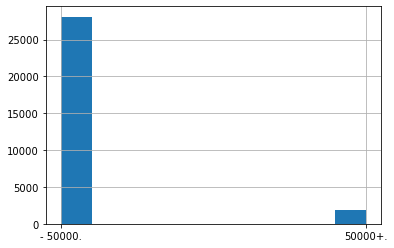

In [43]:
synt_data_cerebras['target'].hist()

In [44]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.30% and 93.70%


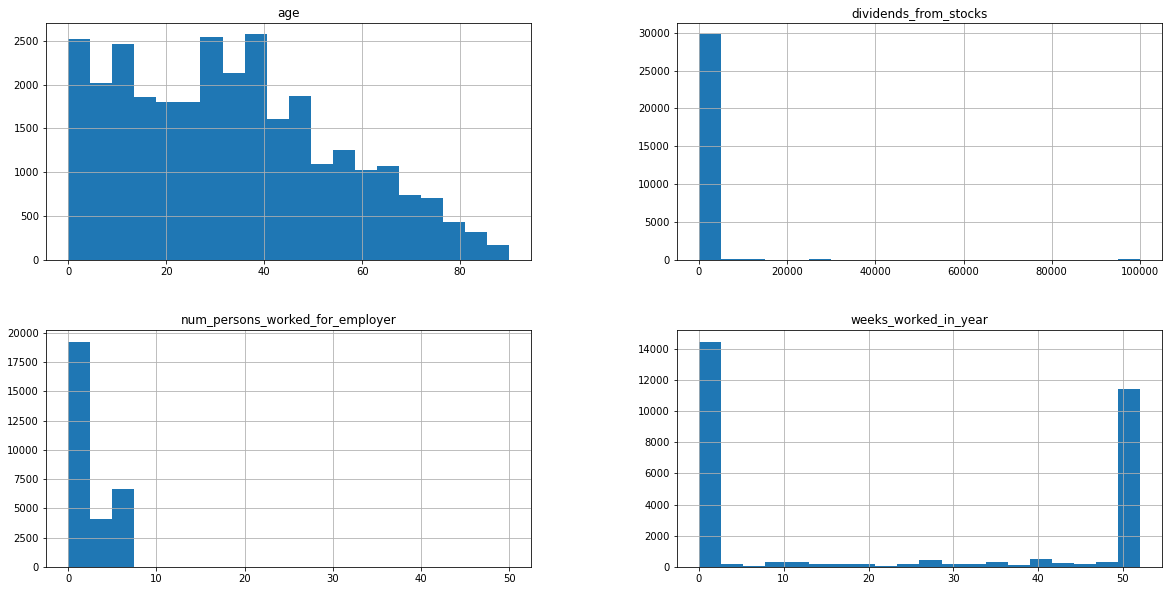

In [45]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

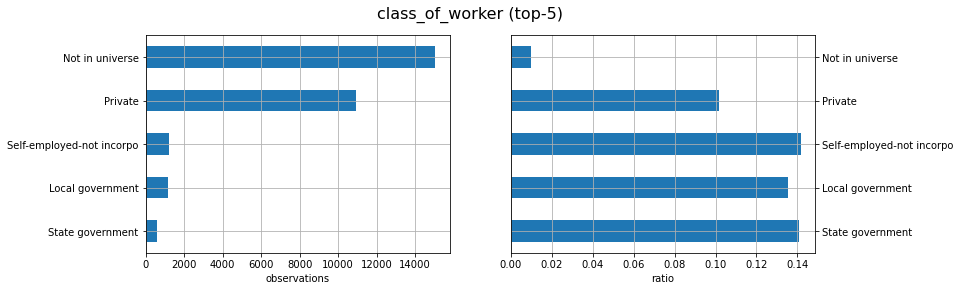

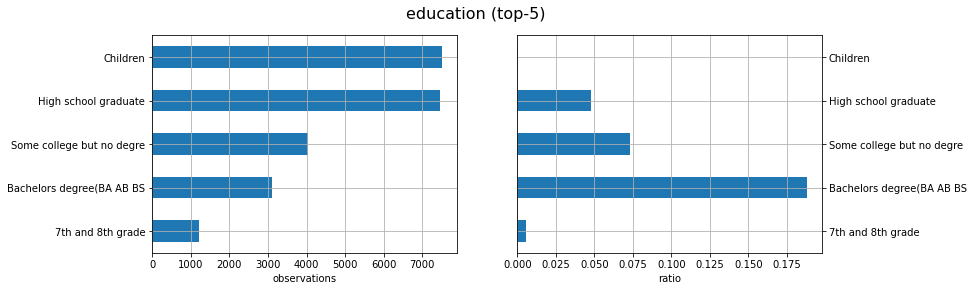

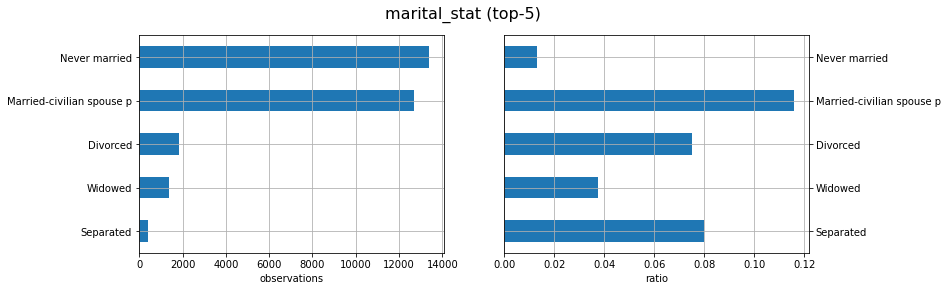

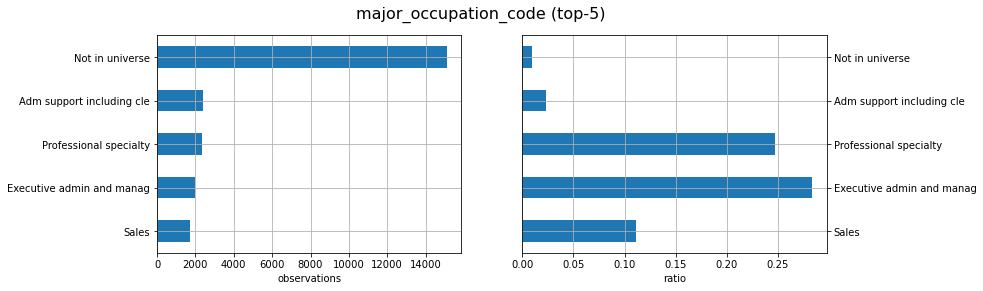

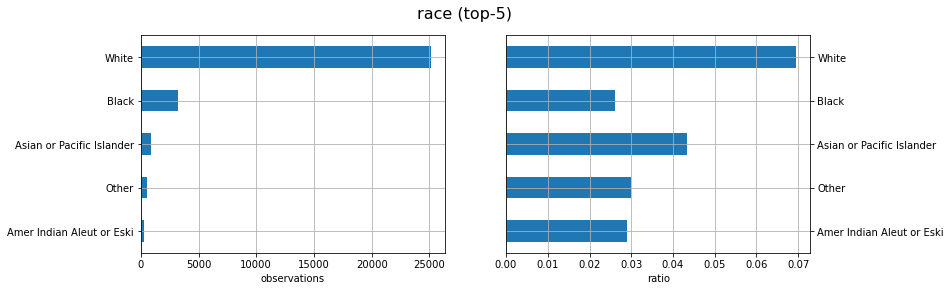

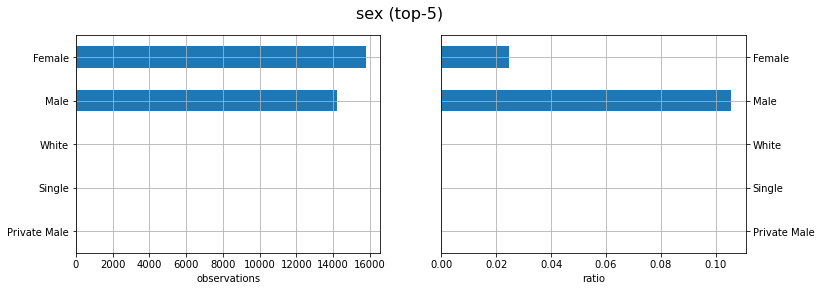

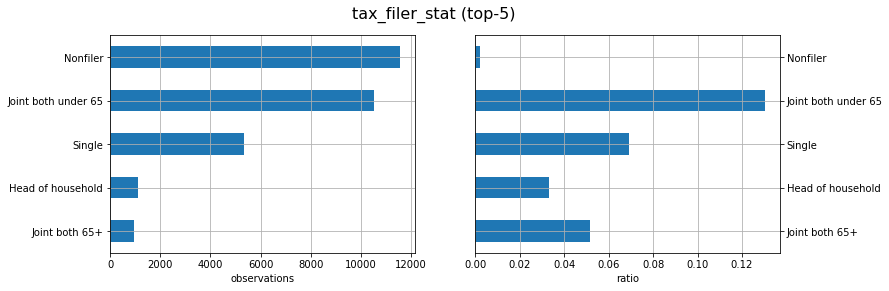

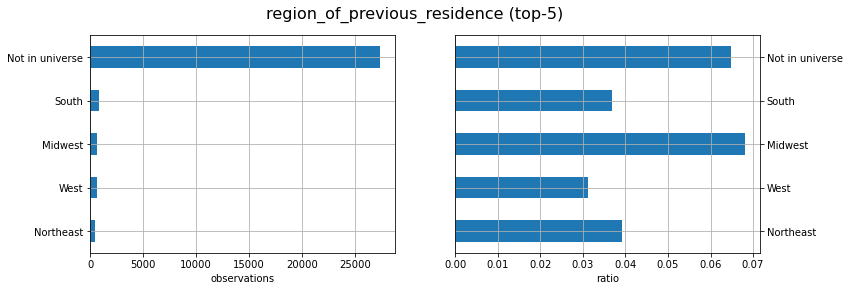

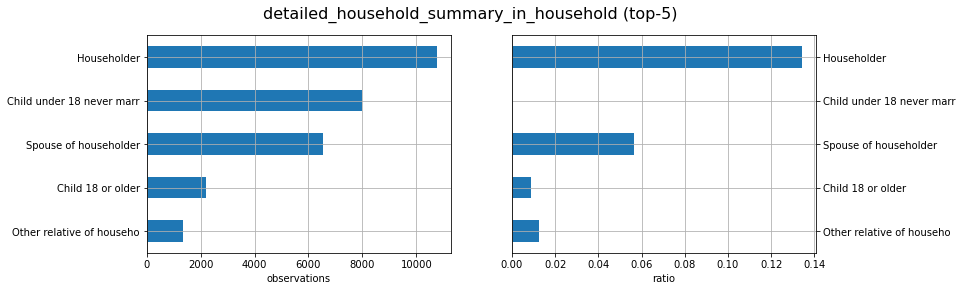

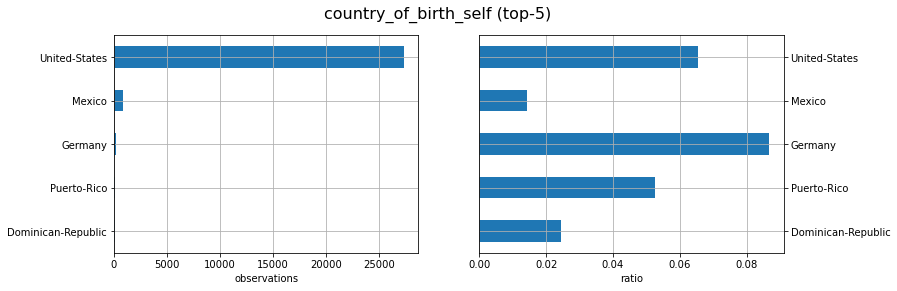

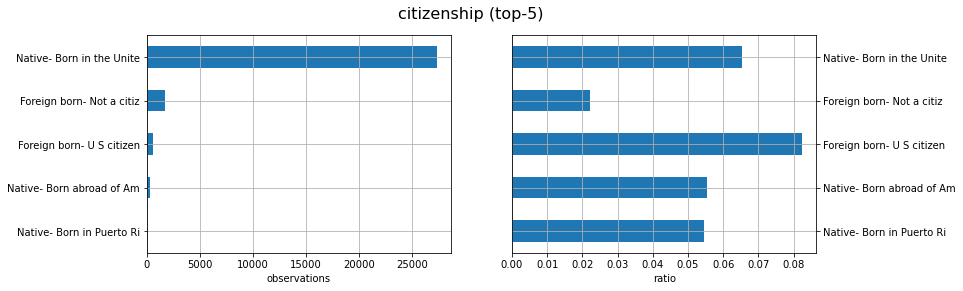

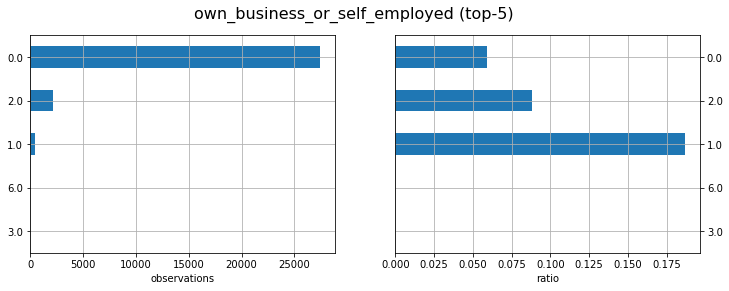

In [46]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [47]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      33.156733             179.792967                         2.039067   
std       21.357365            2673.871268                         2.437896   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       32.000000               0.000000                         1.000000   
75%       47.000000               0.000000                         4.000000   
max       90.000000          200000.000000                        48.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.164267             23.975800  
std                         0.613918             24.505705  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000             12.000000  
75%                         0.000000             52.000000  
max                        52.000000             52.000000

In [48]:
print(synt_data_phi.isna().sum().sum())

0


In [49]:
synt_data_phi['target'].unique()

array(['50000+.', '- 50000.'], dtype=object)

<AxesSubplot:>

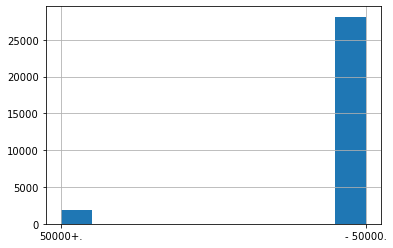

In [50]:
synt_data_phi['target'].hist()

In [51]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.27% and 93.73%


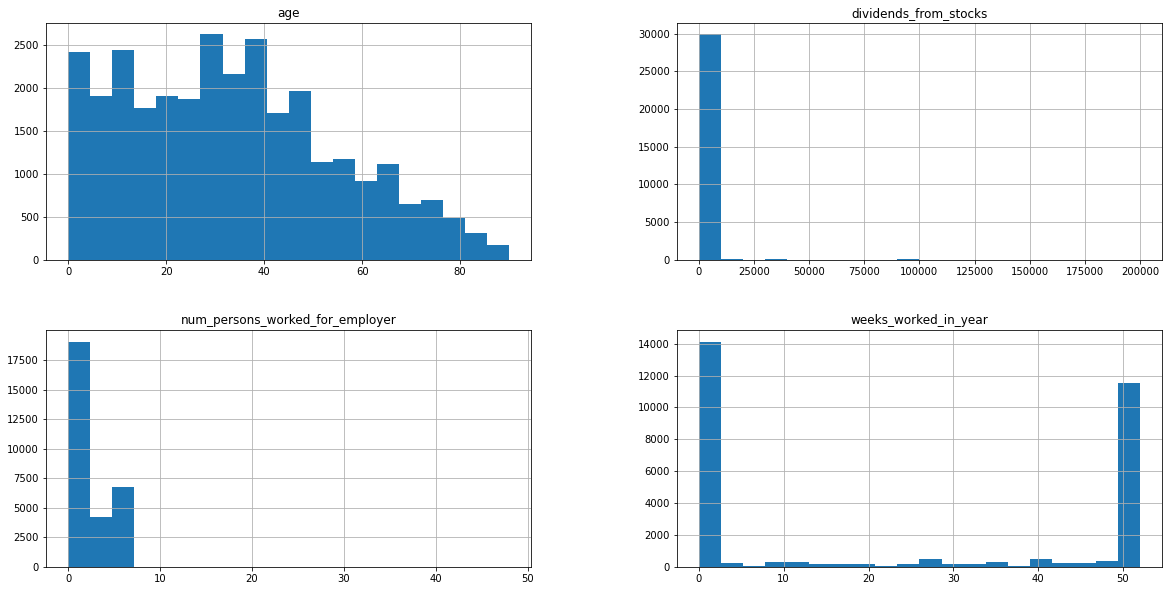

In [52]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

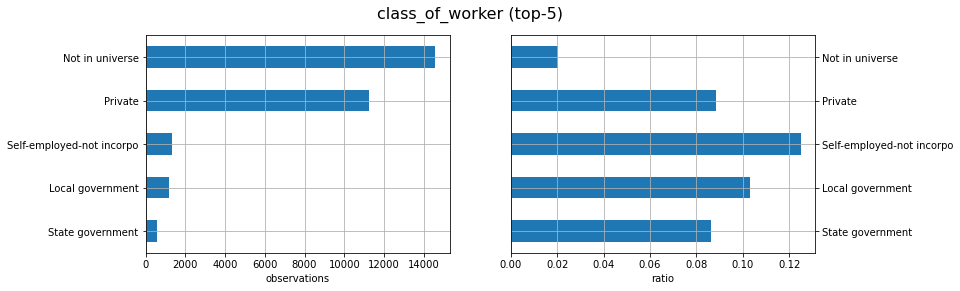

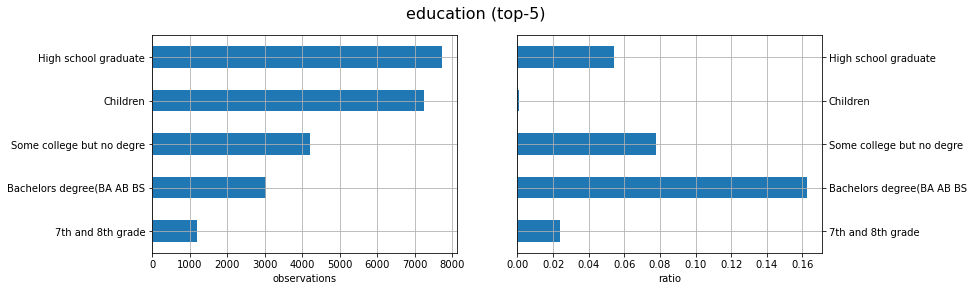

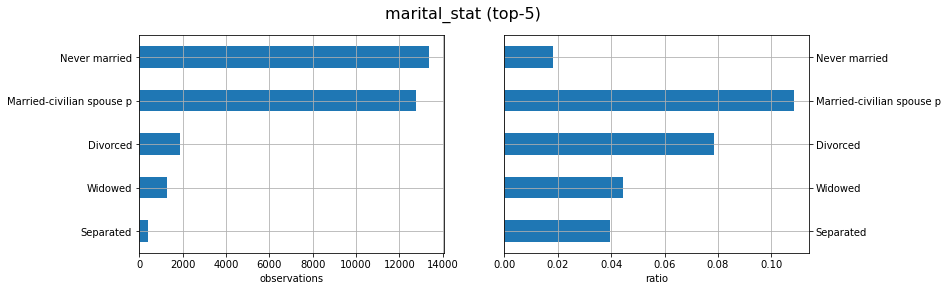

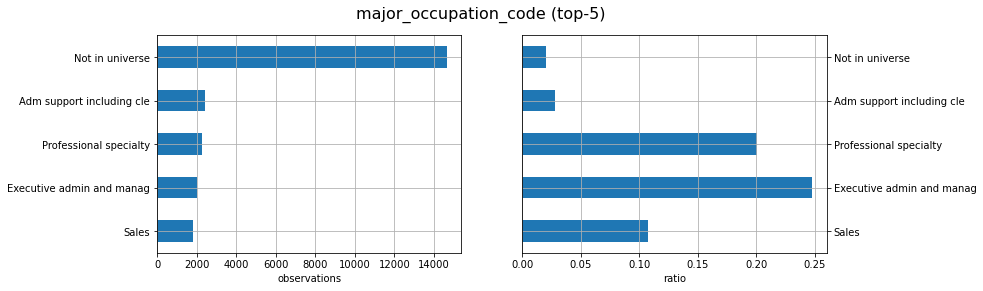

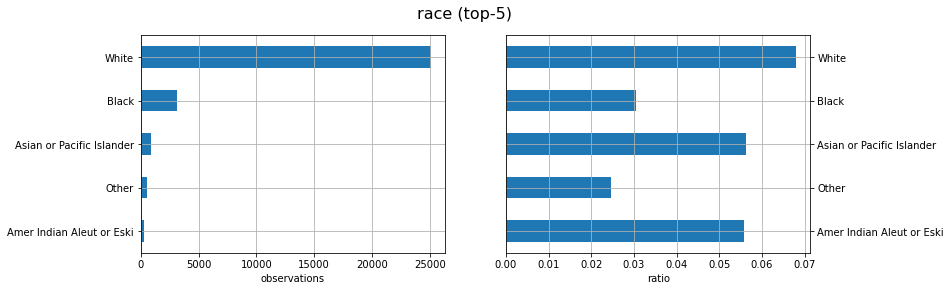

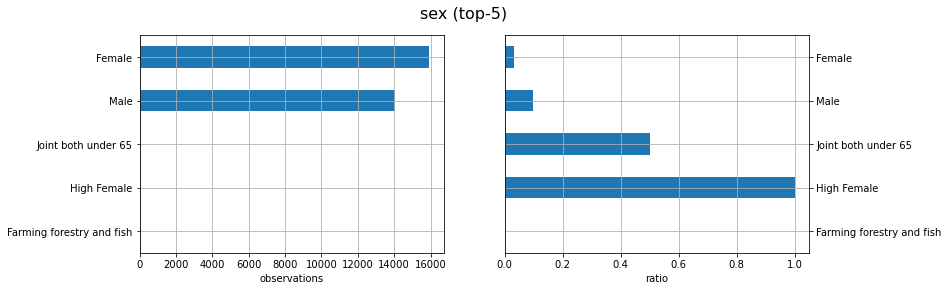

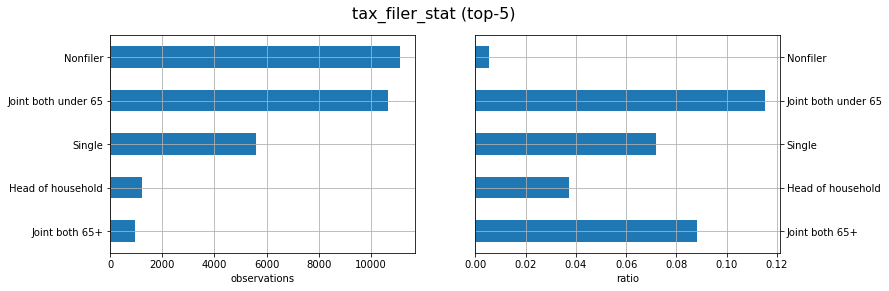

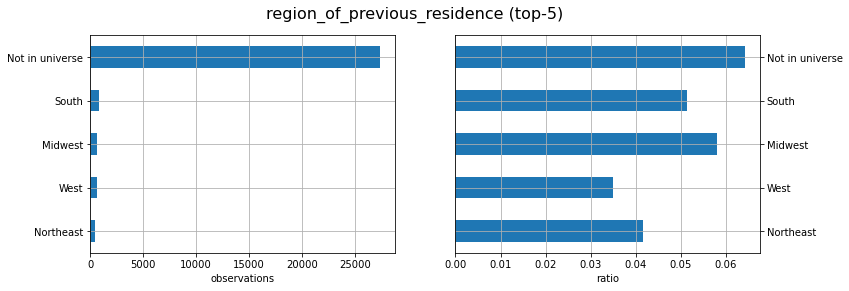

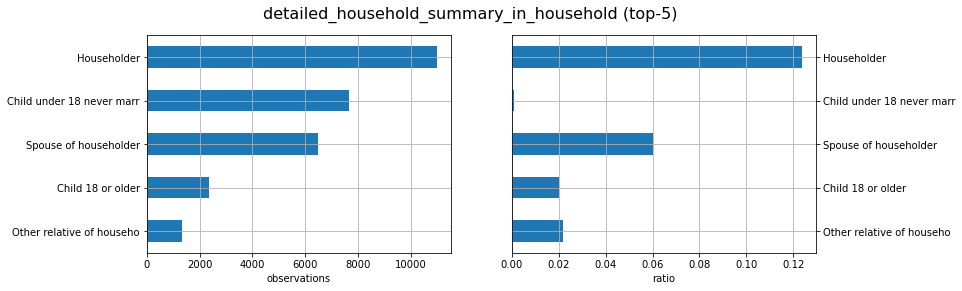

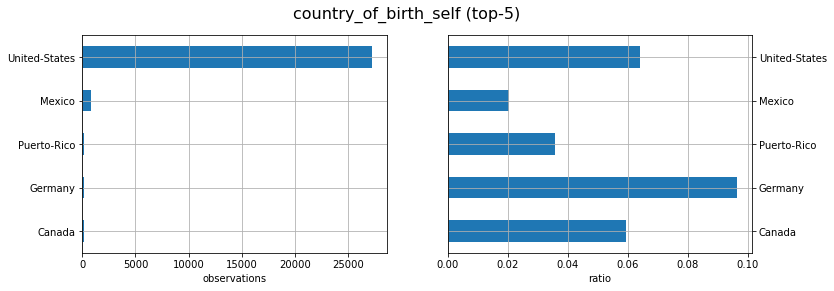

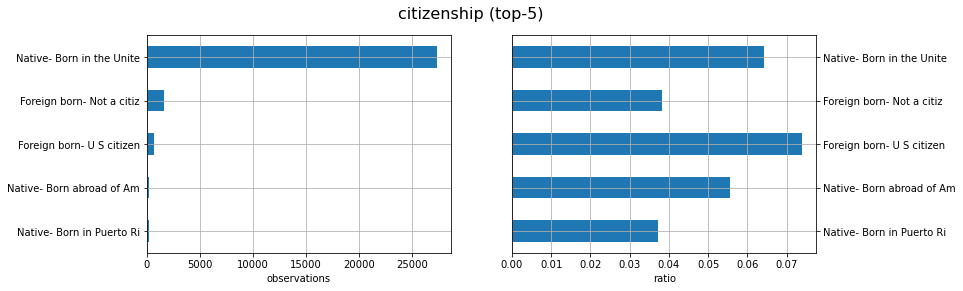

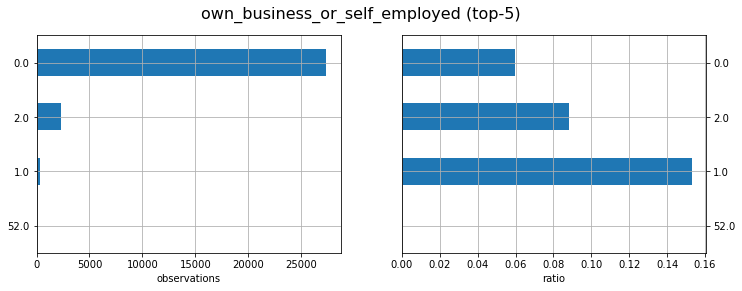

In [53]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [54]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [55]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [56]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

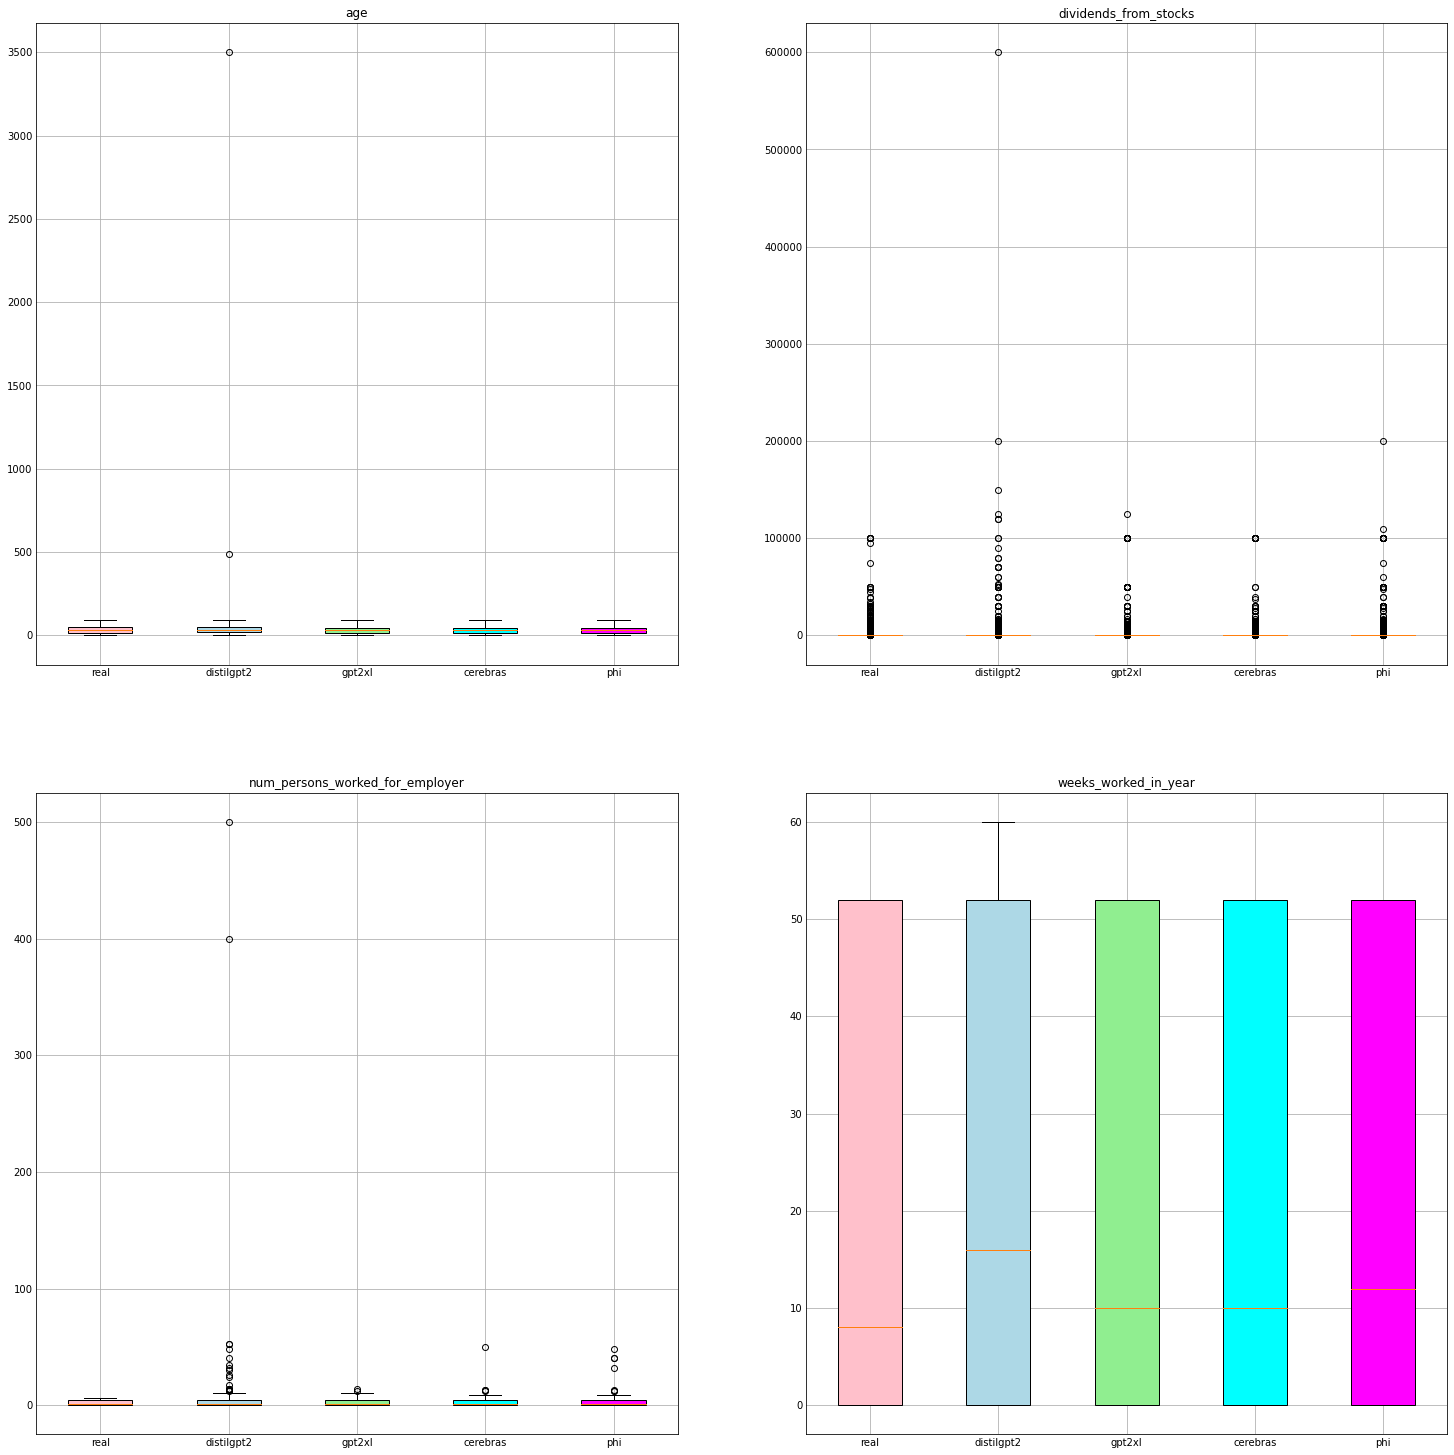

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [58]:
to_encode = [i for i in categs]

In [59]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [60]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [61]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [62]:
real_data = real_dataset.copy()

In [63]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [64]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [65]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [66]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [67]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [68]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [69]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [70]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [71]:
to_encode_real = to_encode.copy() 

In [72]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [73]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [74]:
to_encode_real

[]

In [75]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [76]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [77]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

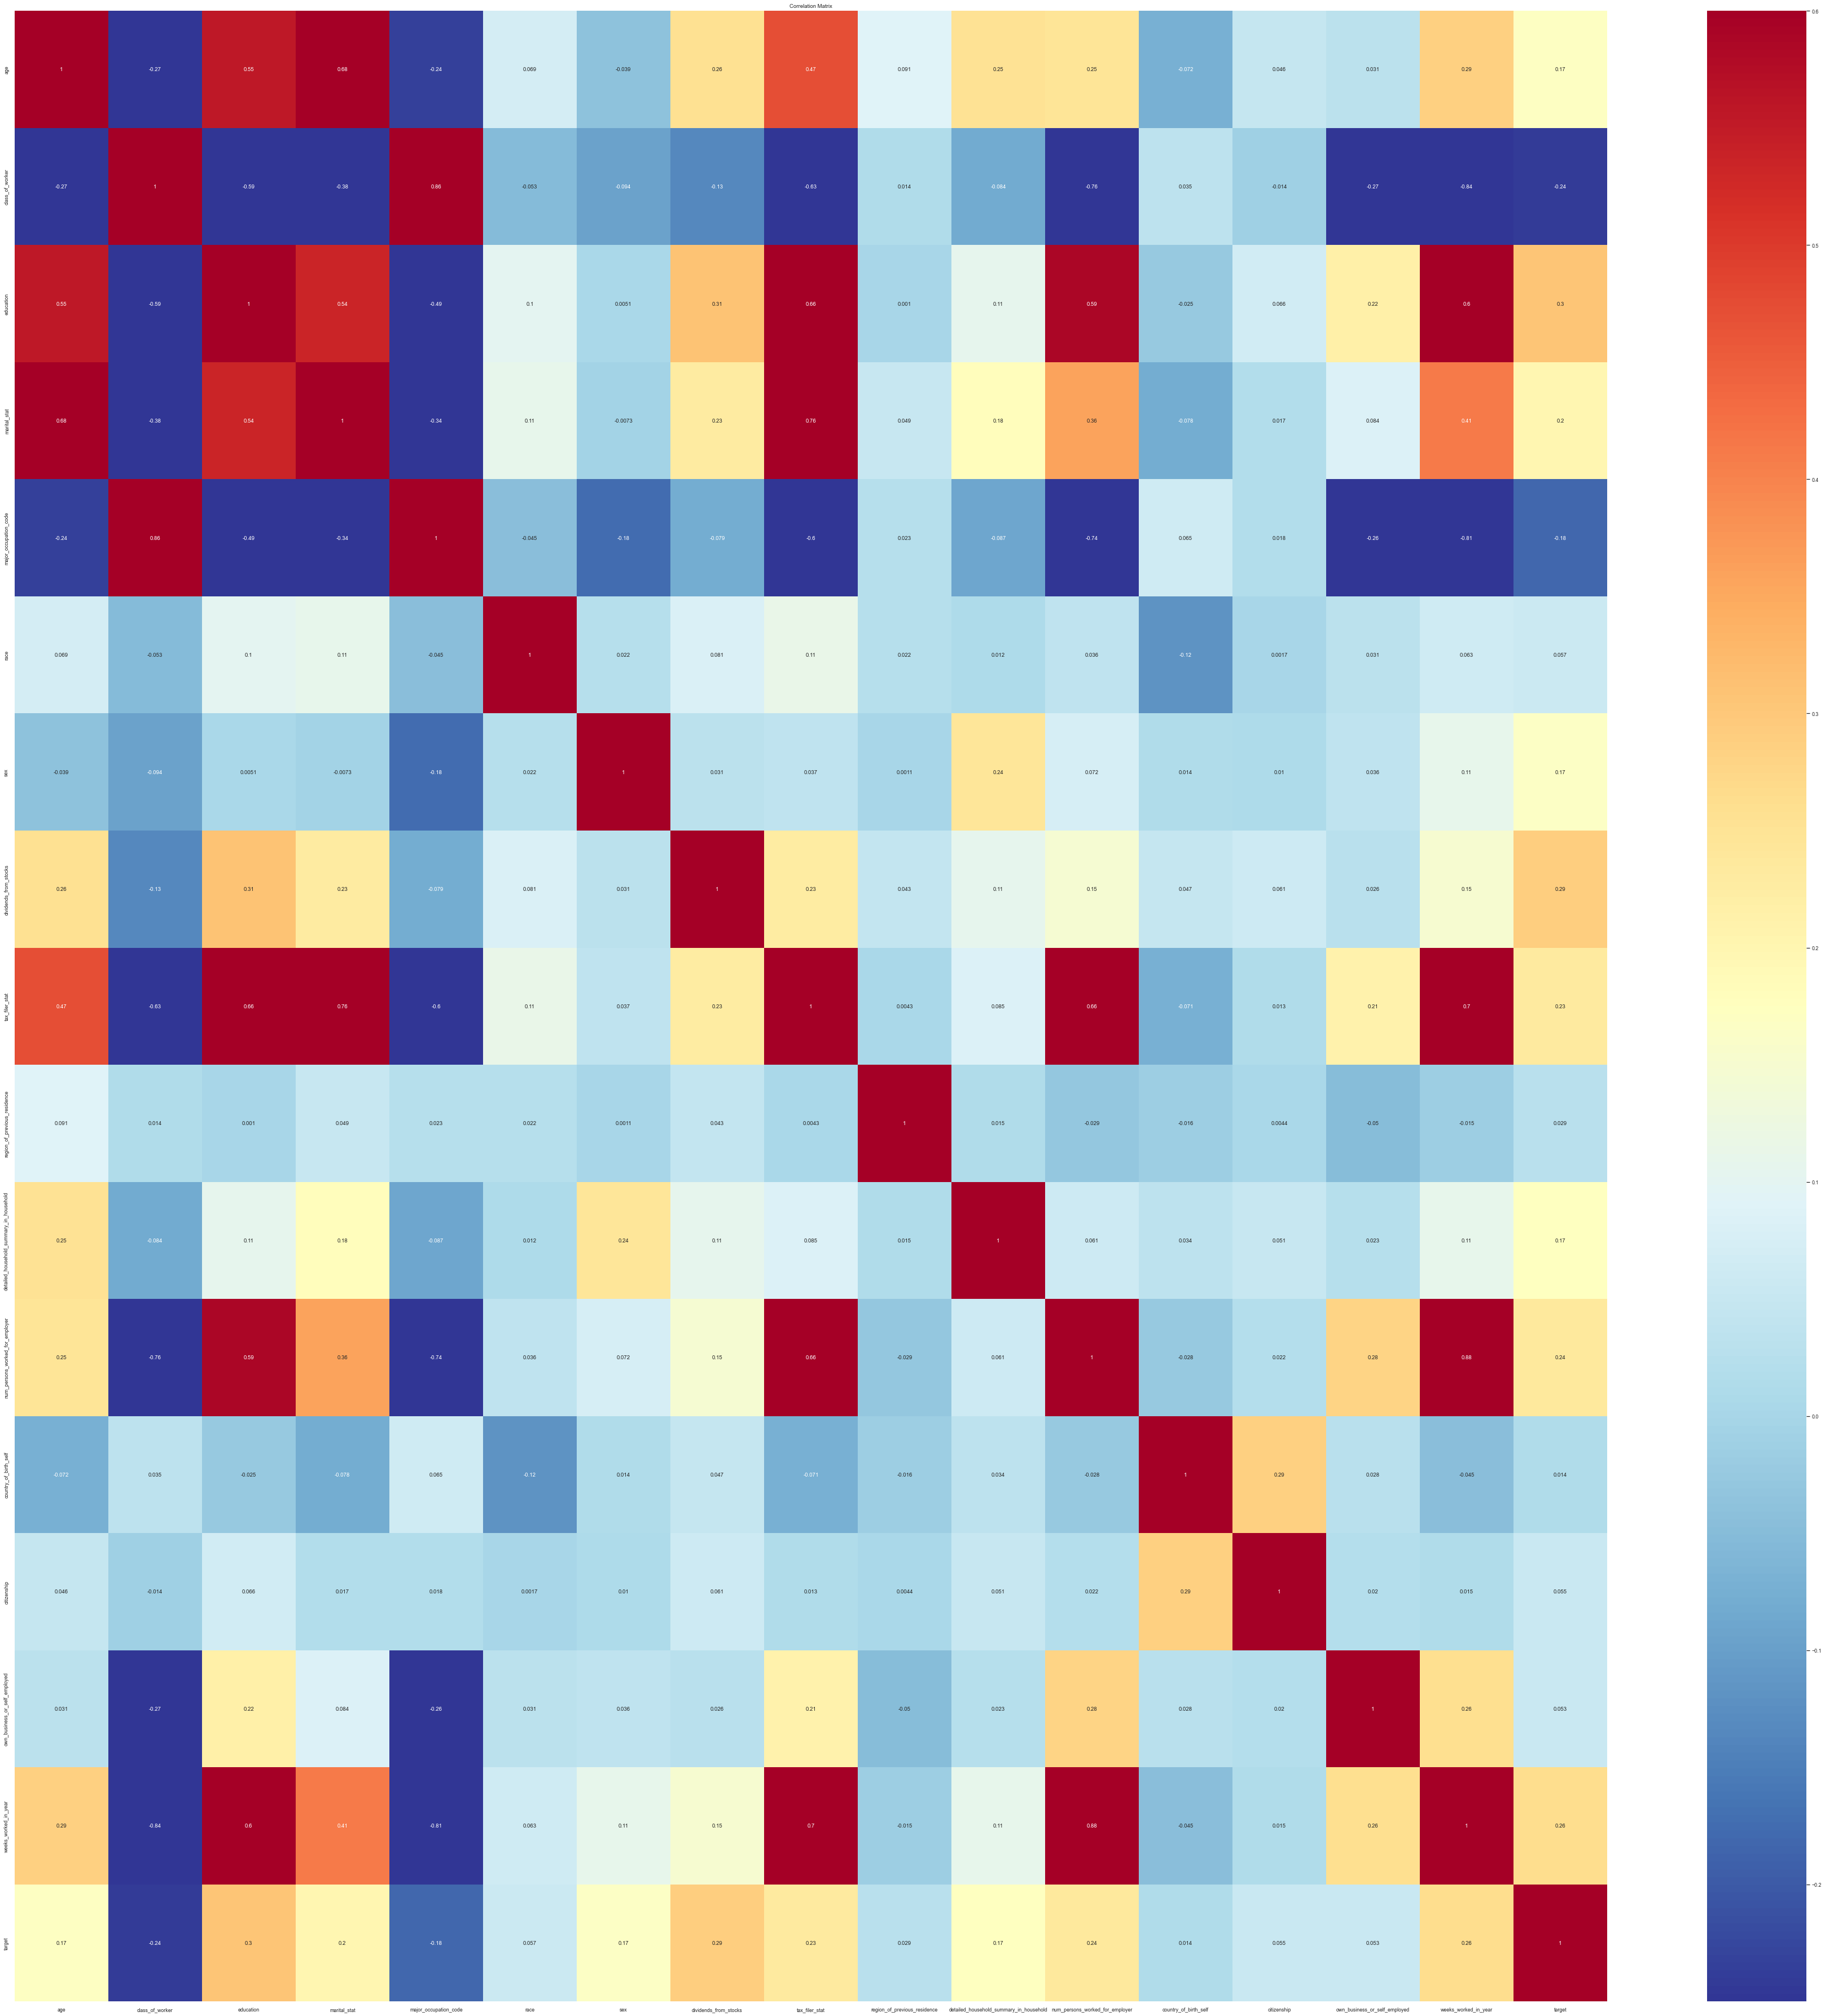

In [78]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [79]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [80]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [81]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [82]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [83]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [84]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [85]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 344 ms
Wall time: 338 ms


In [86]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [87]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [88]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8464060619430963
LogisticRegression(C=0.1, solver='saga')


In [89]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [90]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [91]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [92]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [93]:
synt_data = synt_data_distilgpt2.copy()

In [94]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [95]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [96]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['50000+.' '- 50000.'] 2


In [97]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [98]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [99]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['High school graduate' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Children' '7th and 8th grade' 'Some college but no degree'
 'Bachelors degree(BA AB BS)' '9th grade'
 'Associates degree-academic program' '10th grade' '11th grade'
 'Associates degree-occup /vocational' '12th grade no diploma'
 '5th or 6th grade' '1st 2nd 3rd or 4th grade' 'Doctorate degree(PhD EdD)'
 'Prof school degree (MD DDS DVM LLB JD)' 'Professional specialty'
 '4th or 6th grade' 'Precision production craft & repair'
 '6th or 8th grade' 'Other' 'Not in universe' '3rd or 4th grade'
 '6th and 8th grade' 'Less than 1st grade' '2nd 3rd or 4th grade'
 'Private' 'Masters degree(MA MEng MEd MSW MBA)' '8th and 8th grade'
 'Foreign born- Not a citizen of U S' '30 or 50'
 'Prof school degree (MD DDS DVM Associates)' '17th grade'
 '- 5th or 6th grade' '16 or older'
 'Bachelors degree(Bachelors degree(BA AB BS)' '6th or 7th grade'
 '16th grade' '13th grade' '0' '6th or 6th grade' '15th grade'
 'Doctorate degree (PhD EdD)' '1

In [100]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

Professional specialty
4th or 6th grade
Precision production craft & repair
6th or 8th grade
Other
Not in universe
3rd or 4th grade
6th and 8th grade
2nd 3rd or 4th grade
Private
Masters degree(MA MEng MEd MSW MBA)
8th and 8th grade
Foreign born- Not a citizen of U S
30 or 50
Prof school degree (MD DDS DVM Associates)
17th grade
- 5th or 6th grade
16 or older
Bachelors degree(Bachelors degree(BA AB BS)
6th or 7th grade
16th grade
13th grade
0
6th or 6th grade
15th grade
Doctorate degree (PhD EdD)
1st 2nd 2nd 3rd or 4th grade
14th grade
education
15th grade no diploma
Spouse of householder
Joint both under 65
2nd or 4th grade
3th or 6th grade
4th grade
degree-academic program
Child 18 or older
8th grade no diploma
Less than 1st grade no diploma
Mexico
Associates degree-incorporated
Head of household
Without Borders
40+
Technicians and related support
Associates degree- 7th and 8th grade
Without degree
4th or 5th grade
Associates degree(BA AB BS)
Prof school degree(PhD EdD)
class Bachelo

{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [101]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [102]:
to_encode_synt = to_encode.copy() 

In [103]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [104]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [105]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [106]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [107]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.191536   0.439036   
class_of_worker                         -0.191536         1.000000  -0.481112   
education                                0.439036        -0.481112   1.000000   
marital_stat                             0.256479        -0.231556   0.297208   
major_occupation_code                   -0.159938         0.832689  -0.399864   
race                                     0.065264        -0.034694   0.049568   
sex                                      0.029783         0.051808  -0.008474   
dividends_from_stocks                    0.152991        -0.105080   0.185578   
tax_filer_stat                           0.021660        -0.176305   0.145010   
region_of_previous_residence             0.053874         0.024945   0.004952   
detailed_household_summary_in_household  0.529251        -0.252047   0.354120   
num_persons_worked_for_employer          0.156243        -0.706608   0.471165   
country_of_birth_self                   -0.034671         0.016297  -0.001150   
citizenship                             -0.033011         0.017624   0.000140   
own_business_or_self_employed           -0.022571         0.215496  -0.142506   
weeks_worked_in_year                     0.190415        -0.781586   0.492728   
target                                   0.104847        -0.080345   0.101489   

                                         marital_stat  major_occupation_code  \
age                                          0.256479              -0.159938   
class_of_worker                             -0.231556               0.832689   
education                                    0.297208              -0.399864   
marital_stat                                 1.000000              -0.197572   
major_occupation_code                       -0.197572               1.000000   
race                                         0.063263              -0.038183   
sex                                         -0.014385               0.087807   
dividends_from_stocks                        0.121321              -0.088026   
tax_filer_stat                               0.608863              -0.142362   
region_of_previous_residence                 0.014199               0.029097   
detailed_household_summary_in_household      0.238055              -0.232019   
num_persons_worked_for_employer              0.219691              -0.683665   
country_of_birth_self                       -0.021284               0.023127   
citizenship                                 -0.018670               0.024687   
own_business_or_self_employed               -0.056134               0.209346   
weeks_worked_in_year                         0.245589              -0.750823   
target                                       0.059274              -0.065567   

                                             race       sex  \
age                                      0.065264  0.029783   
class_of_worker                         -0.034694  0.051808   
education                                0.049568 -0.008474   
marital_stat                             0.063263 -0.014385   
major_occupation_code                   -0.038183  0.087807   
race                                     1.000000  0.009117   
sex                                      0.009117  1.000000   
dividends_from_stocks                    0.017456 -0.001124   
tax_filer_stat                           0.050222 -0.006400   
region_of_previous_residence            -0.004136  0.019897   
detailed_household_summary_in_household  0.060912 -0.138792   
num_persons_worked_for_employer          0.035762 -0.048426   
country_of_birth_self                    0.127159 -0.010636   
citizenship                              0.120050 -0.007985   
own_business_or_self_employed           -0.004595  0.037295   
weeks_worked_in_year                     0.034809 -0.051856   
target                                   0.005503 -0.030830   

           

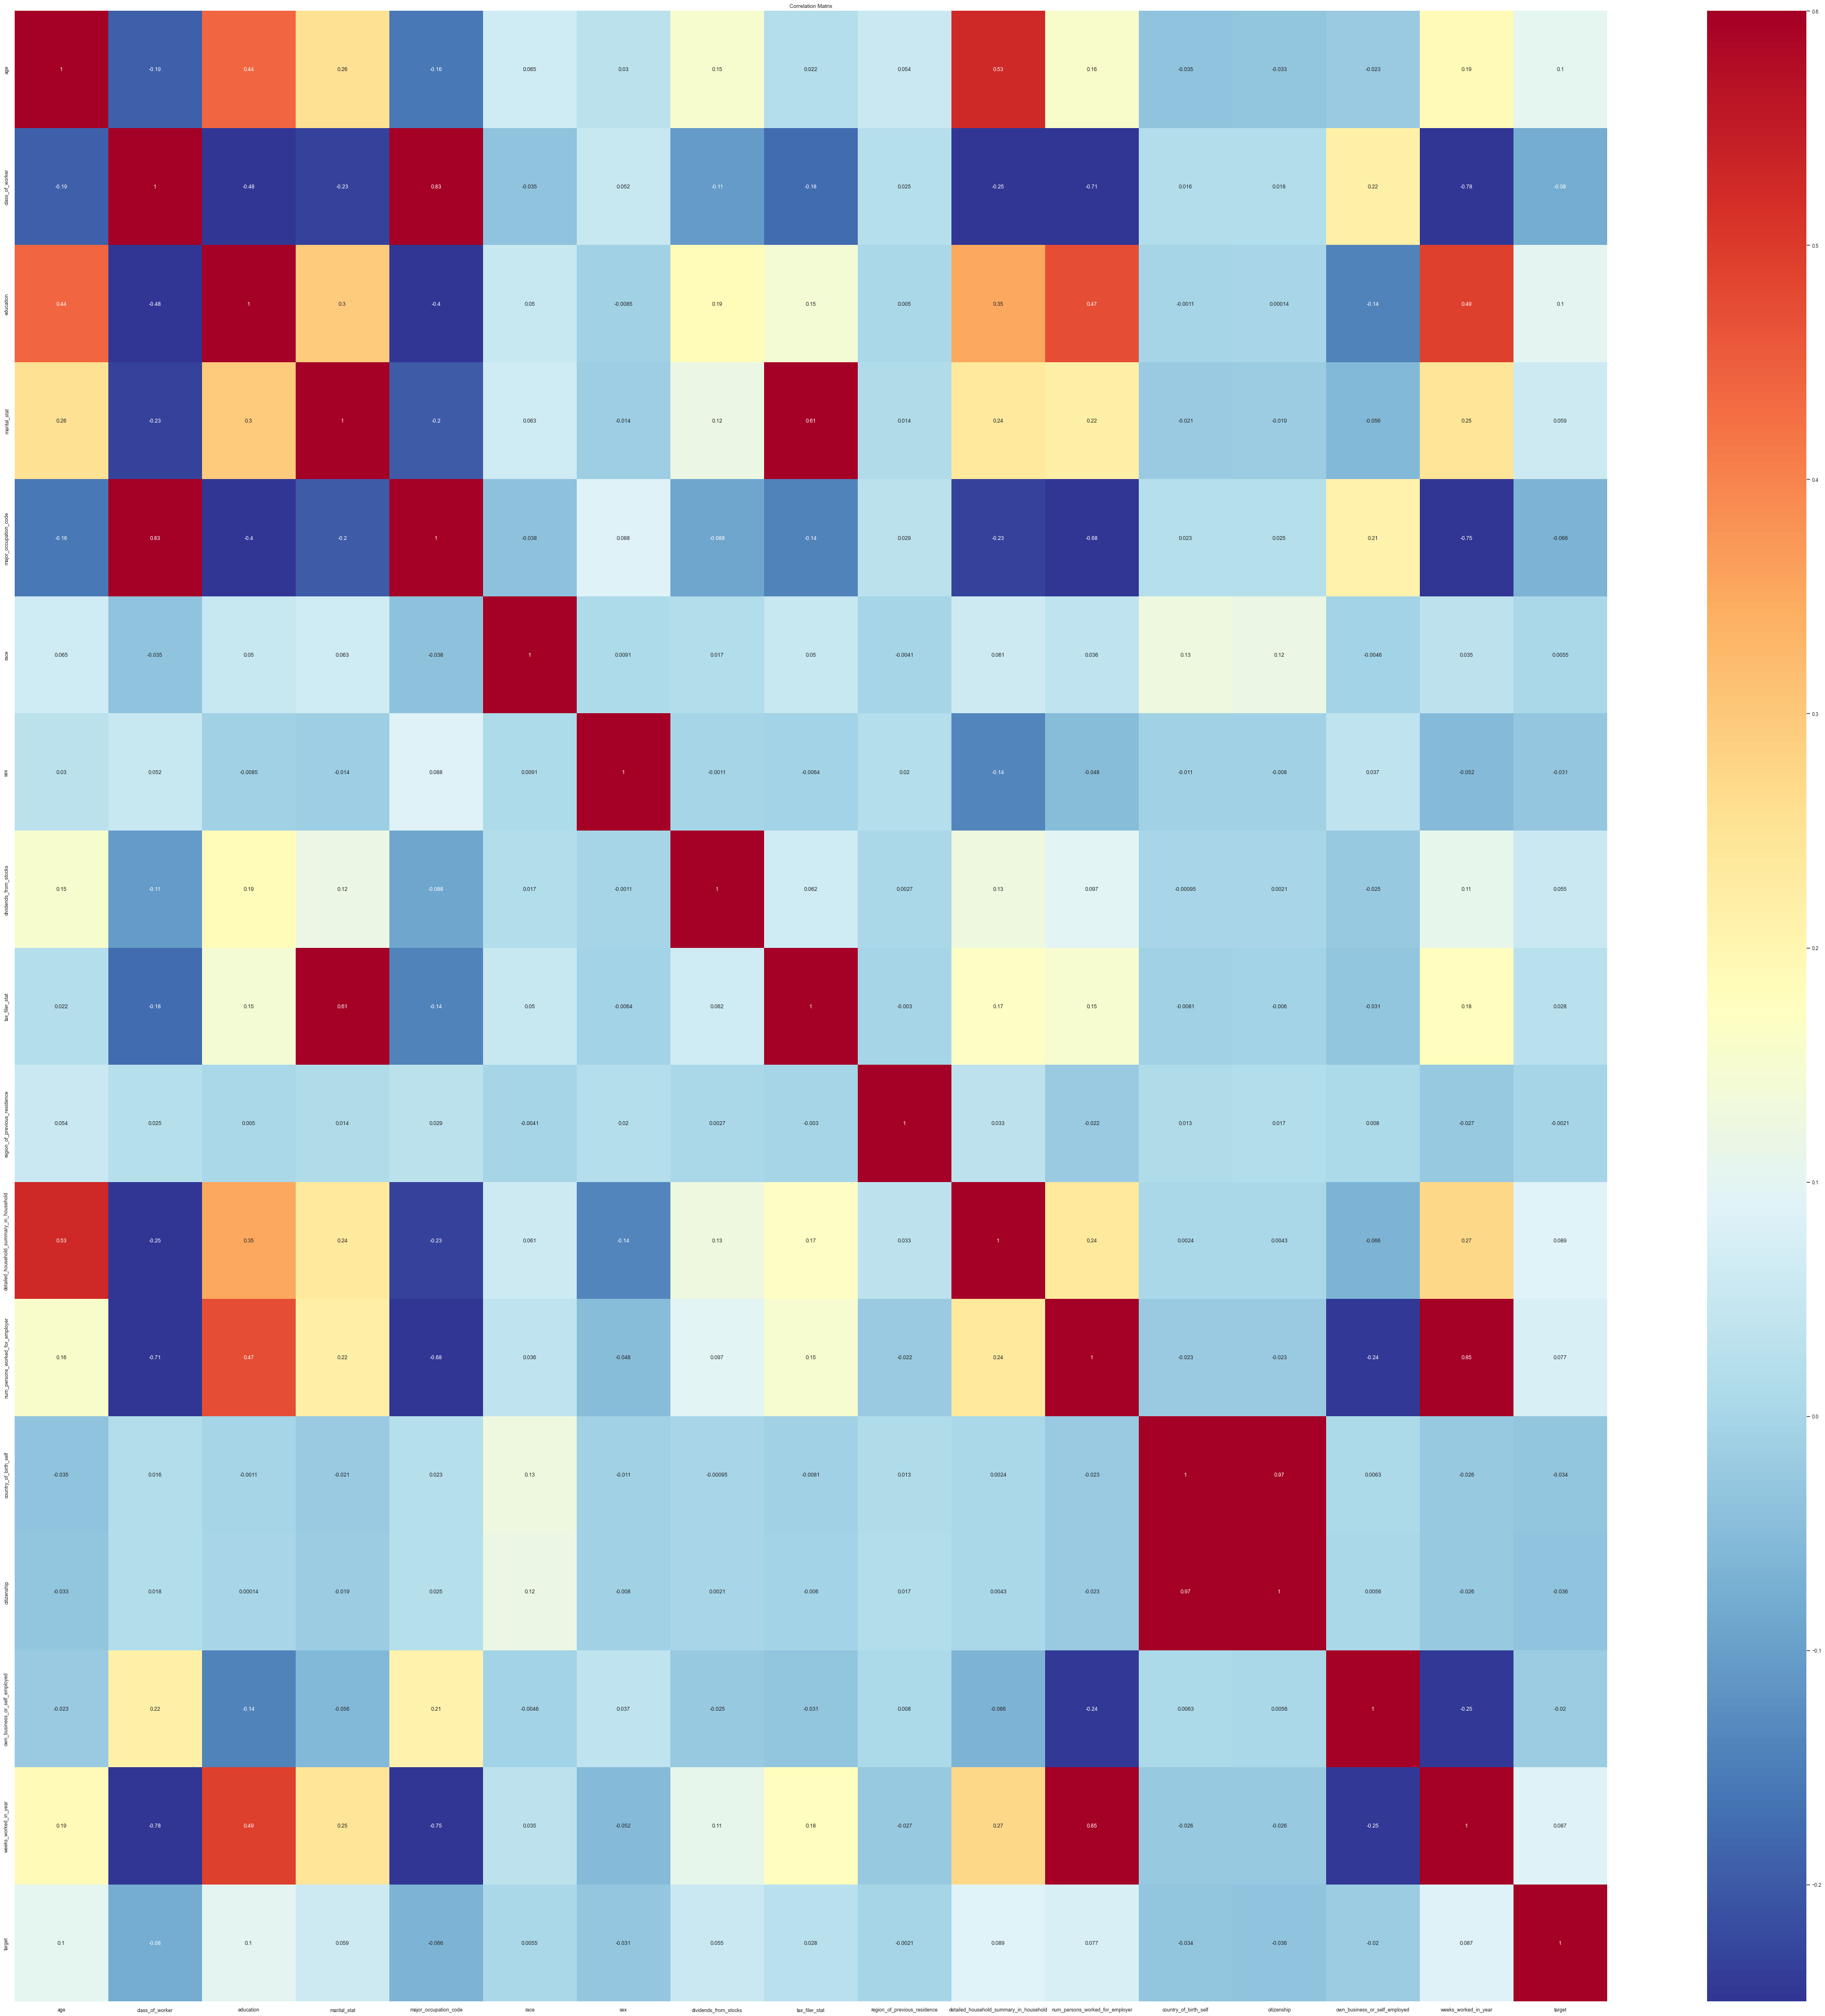

In [108]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [109]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.55:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 5
The number of features remaining: 11


In [110]:
del_features

array(['class_of_worker', 'country_of_birth_self',
       'major_occupation_code', 'num_persons_worked_for_employer',
       'tax_filer_stat'], dtype='<U31')

In [111]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 11


In [112]:
sorted(count_features)

['age',
 'citizenship',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'weeks_worked_in_year']

In [113]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [114]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [115]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [116]:
y_tr.isna().sum()

0

In [117]:
X_te2.isna().sum()

age                                         0
education                                   0
marital_stat                                2
race                                        2
sex                                         2
dividends_from_stocks                       0
tax_filer_stat                              8
region_of_previous_residence                8
detailed_household_summary_in_household     5
country_of_birth_self                       1
citizenship                                10
own_business_or_self_employed               1
weeks_worked_in_year                        0
dtype: int64

In [118]:
X_te_real1.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [119]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       96
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [120]:
sorted(synt_data['citizenship'].unique()) 


['17th and 4th grade',
 'Adm support including clerical',
 'Amer Indian Aleut or Eskimo',
 'Asian or Pacific Islander',
 'Black',
 'Dominican-Republic',
 'El-Salvador',
 'Female',
 'Foreign born abroad of U S',
 'Foreign born in the United States',
 'Foreign born- 24/hr(s)',
 'Foreign born- Federal citizen by naturalization',
 'Foreign born- Foreign born- Not a citizen of U S',
 'Foreign born- Foreign born- U S citizen by naturalization',
 'Foreign born- Never married',
 'Foreign born- Not a U S citizen by naturalization',
 'Foreign born- Not a citizen of American citizen of U S',
 'Foreign born- Not a citizen of U S',
 'Foreign born- Not in universe',
 'Foreign born- Spouse of American Parent',
 'Foreign born- U S',
 'Foreign born- U S citizen by naturalization',
 'Foreign born- United-States',
 'Foreign born- citizen of U S',
 'Foreign born-incorporated',
 'Foreign born-not a citizen of U S',
 'Japan',
 'Local government',
 'Married-civilian spouse present',
 'Native- Born In the Uni

In [121]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [122]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, i

In [123]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 297 ms
Wall time: 289 ms


In [124]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.632 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.606 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.612 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.604 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.582 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.638 total time=   0.5s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.610 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.606 total time=   0.7s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.605 total time=   0.6s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.589 total time=   0.6s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.640 total time=   0.7s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [125]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6094463876546765
LogisticRegression(C=0.001, solver='saga')


In [126]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [127]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [128]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [129]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 328 ms
Wall time: 343 ms


In [130]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.632 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.608 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.612 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.602 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.589 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.635 total time=   0.7s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.616 total time=   0.3s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.606 total time=   1.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.601 total time=   0.9s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.597 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.637 total time=   2.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.617 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.601 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.602 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.599 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.637 total time=   2.0s
[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.617 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.600 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.602 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.598 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.636 total time=   2.1s
[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.617 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.600 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.602 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.598 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.636 total time=   2.2s
[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.617 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.600 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.602 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.598 total time=   2.0s
CPU times: total: 51.1 s
Wall time: 51.6 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [131]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.6110386927220491
LogisticRegression(C=0.01, solver='saga')


In [132]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [133]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [134]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [135]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.633827   

     Recall  Precision   ROC_AUC  
0  0.729659   0.096729  0.633827

In [136]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test           0.771681   

     Recall  Precision   ROC_AUC  
0  0.962963   0.133676  0.771681

## GPT2XL classification

### Data preprocessing 

In [137]:
synt_data = synt_data_gpt2xl.copy()

In [138]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [139]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [140]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [141]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [142]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' '5th or 6th grade' '11th grade' 'Bachelors degree(BA AB BS)'
 'High school graduate' 'Some college but no degree' '7th and 8th grade'
 '9th grade' 'Associates degree-occup /vocational' '12th grade no diploma'
 'Doctorate degree(PhD EdD)' 'Associates degree-academic program'
 '1st 2nd 3rd or 4th grade' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Prof school degree (MD DDS DVM LLB JD)' 'Less than 1st grade'
 '6th or 7th grade' 'Other 10th grade' '15th grade' 'White'
 'Child under 18 never married' '4th or 5th grade' '0'
 'Associates degree-lacademic program' 'Associates degree-incorporated'
 '13th and 14th grade' '3rd or 4th grade' 'Professional specialty'
 'Never 10th grade' '6th grade' 'Adm support including clerical'
 '8th grade' 'Children 18 or older' 'Child 18 or older' '2'
 'Other High school graduate' '- 50000.' '2nd 3rd or 4th grade' '4'
 'Head of household' 'Black'] 42


In [143]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [144]:
to_encode_synt = to_encode.copy() 

In [145]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [146]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [147]:
print(X_tr.isna().sum())

age                                         0
class_of_worker                             0
education                                  14
marital_stat                                0
major_occupation_code                       0
race                                        0
sex                                         0
dividends_from_stocks                       0
tax_filer_stat                              0
region_of_previous_residence                0
detailed_household_summary_in_household     0
num_persons_worked_for_employer             0
country_of_birth_self                       0
citizenship                                 0
own_business_or_self_employed               0
weeks_worked_in_year                        0
dtype: int64


In [148]:
X_tr.fillna(0,inplace=True)

In [149]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [150]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.339052   0.581553   
class_of_worker                         -0.339052         1.000000  -0.606591   
education                                0.581553        -0.606591   1.000000   
marital_stat                            -0.751994         0.335962  -0.496428   
major_occupation_code                   -0.295681         0.861497  -0.510715   
race                                     0.101174        -0.074901   0.089021   
sex                                      0.023525         0.093995  -0.009646   
dividends_from_stocks                    0.221554        -0.157231   0.270666   
tax_filer_stat                          -0.546047         0.530955  -0.610490   
region_of_previous_residence             0.074051         0.012285  -0.003944   
detailed_household_summary_in_household  0.251544        -0.087987   0.112178   
num_persons_worked_for_employer          0.311410        -0.768660   0.607578   
country_of_birth_self                   -0.050346         0.027135  -0.001675   
citizenship                             -0.050749         0.027077   0.000161   
own_business_or_self_employed           -0.057100         0.258387  -0.213666   
weeks_worked_in_year                     0.350936        -0.840002   0.624875   
target                                   0.187404        -0.236934   0.294480   

                                         marital_stat  major_occupation_code  \
age                                         -0.751994              -0.295681   
class_of_worker                              0.335962               0.861497   
education                                   -0.496428              -0.510715   
marital_stat                                 1.000000               0.292272   
major_occupation_code                        0.292272               1.000000   
race                                        -0.089677              -0.072905   
sex                                         -0.080067               0.167010   
dividends_from_stocks                       -0.162575              -0.104047   
tax_filer_stat                               0.422173               0.524492   
region_of_previous_residence                -0.037133               0.017134   
detailed_household_summary_in_household     -0.289906              -0.084152   
num_persons_worked_for_employer             -0.316983              -0.739690   
country_of_birth_self                        0.057297               0.055770   
citizenship                                  0.056766               0.055694   
own_business_or_self_employed                0.073202               0.257021   
weeks_worked_in_year                        -0.360499              -0.809657   
target                                      -0.149814              -0.174227   

                                             race       sex  \
age                                      0.101174  0.023525   
class_of_worker                         -0.074901  0.093995   
education                                0.089021 -0.009646   
marital_stat                            -0.089677 -0.080067   
major_occupation_code                   -0.072905  0.167010   
race                                     1.000000 -0.023484   
sex                                     -0.023484  1.000000   
dividends_from_stocks                    0.077700 -0.042796   
tax_filer_stat                          -0.088708  0.007842   
region_of_previous_residence             0.022353 -0.017298   
detailed_household_summary_in_household  0.055234 -0.239586   
num_persons_worked_for_employer          0.057380 -0.064407   
country_of_birth_self                    0.134413 -0.014214   
citizenship                              0.126686 -0.012498   
own_business_or_self_employed           -0.044732  0.033061   
weeks_worked_in_year                     0.078634 -0.106081   
target                                   0.051910 -0.157234   

           

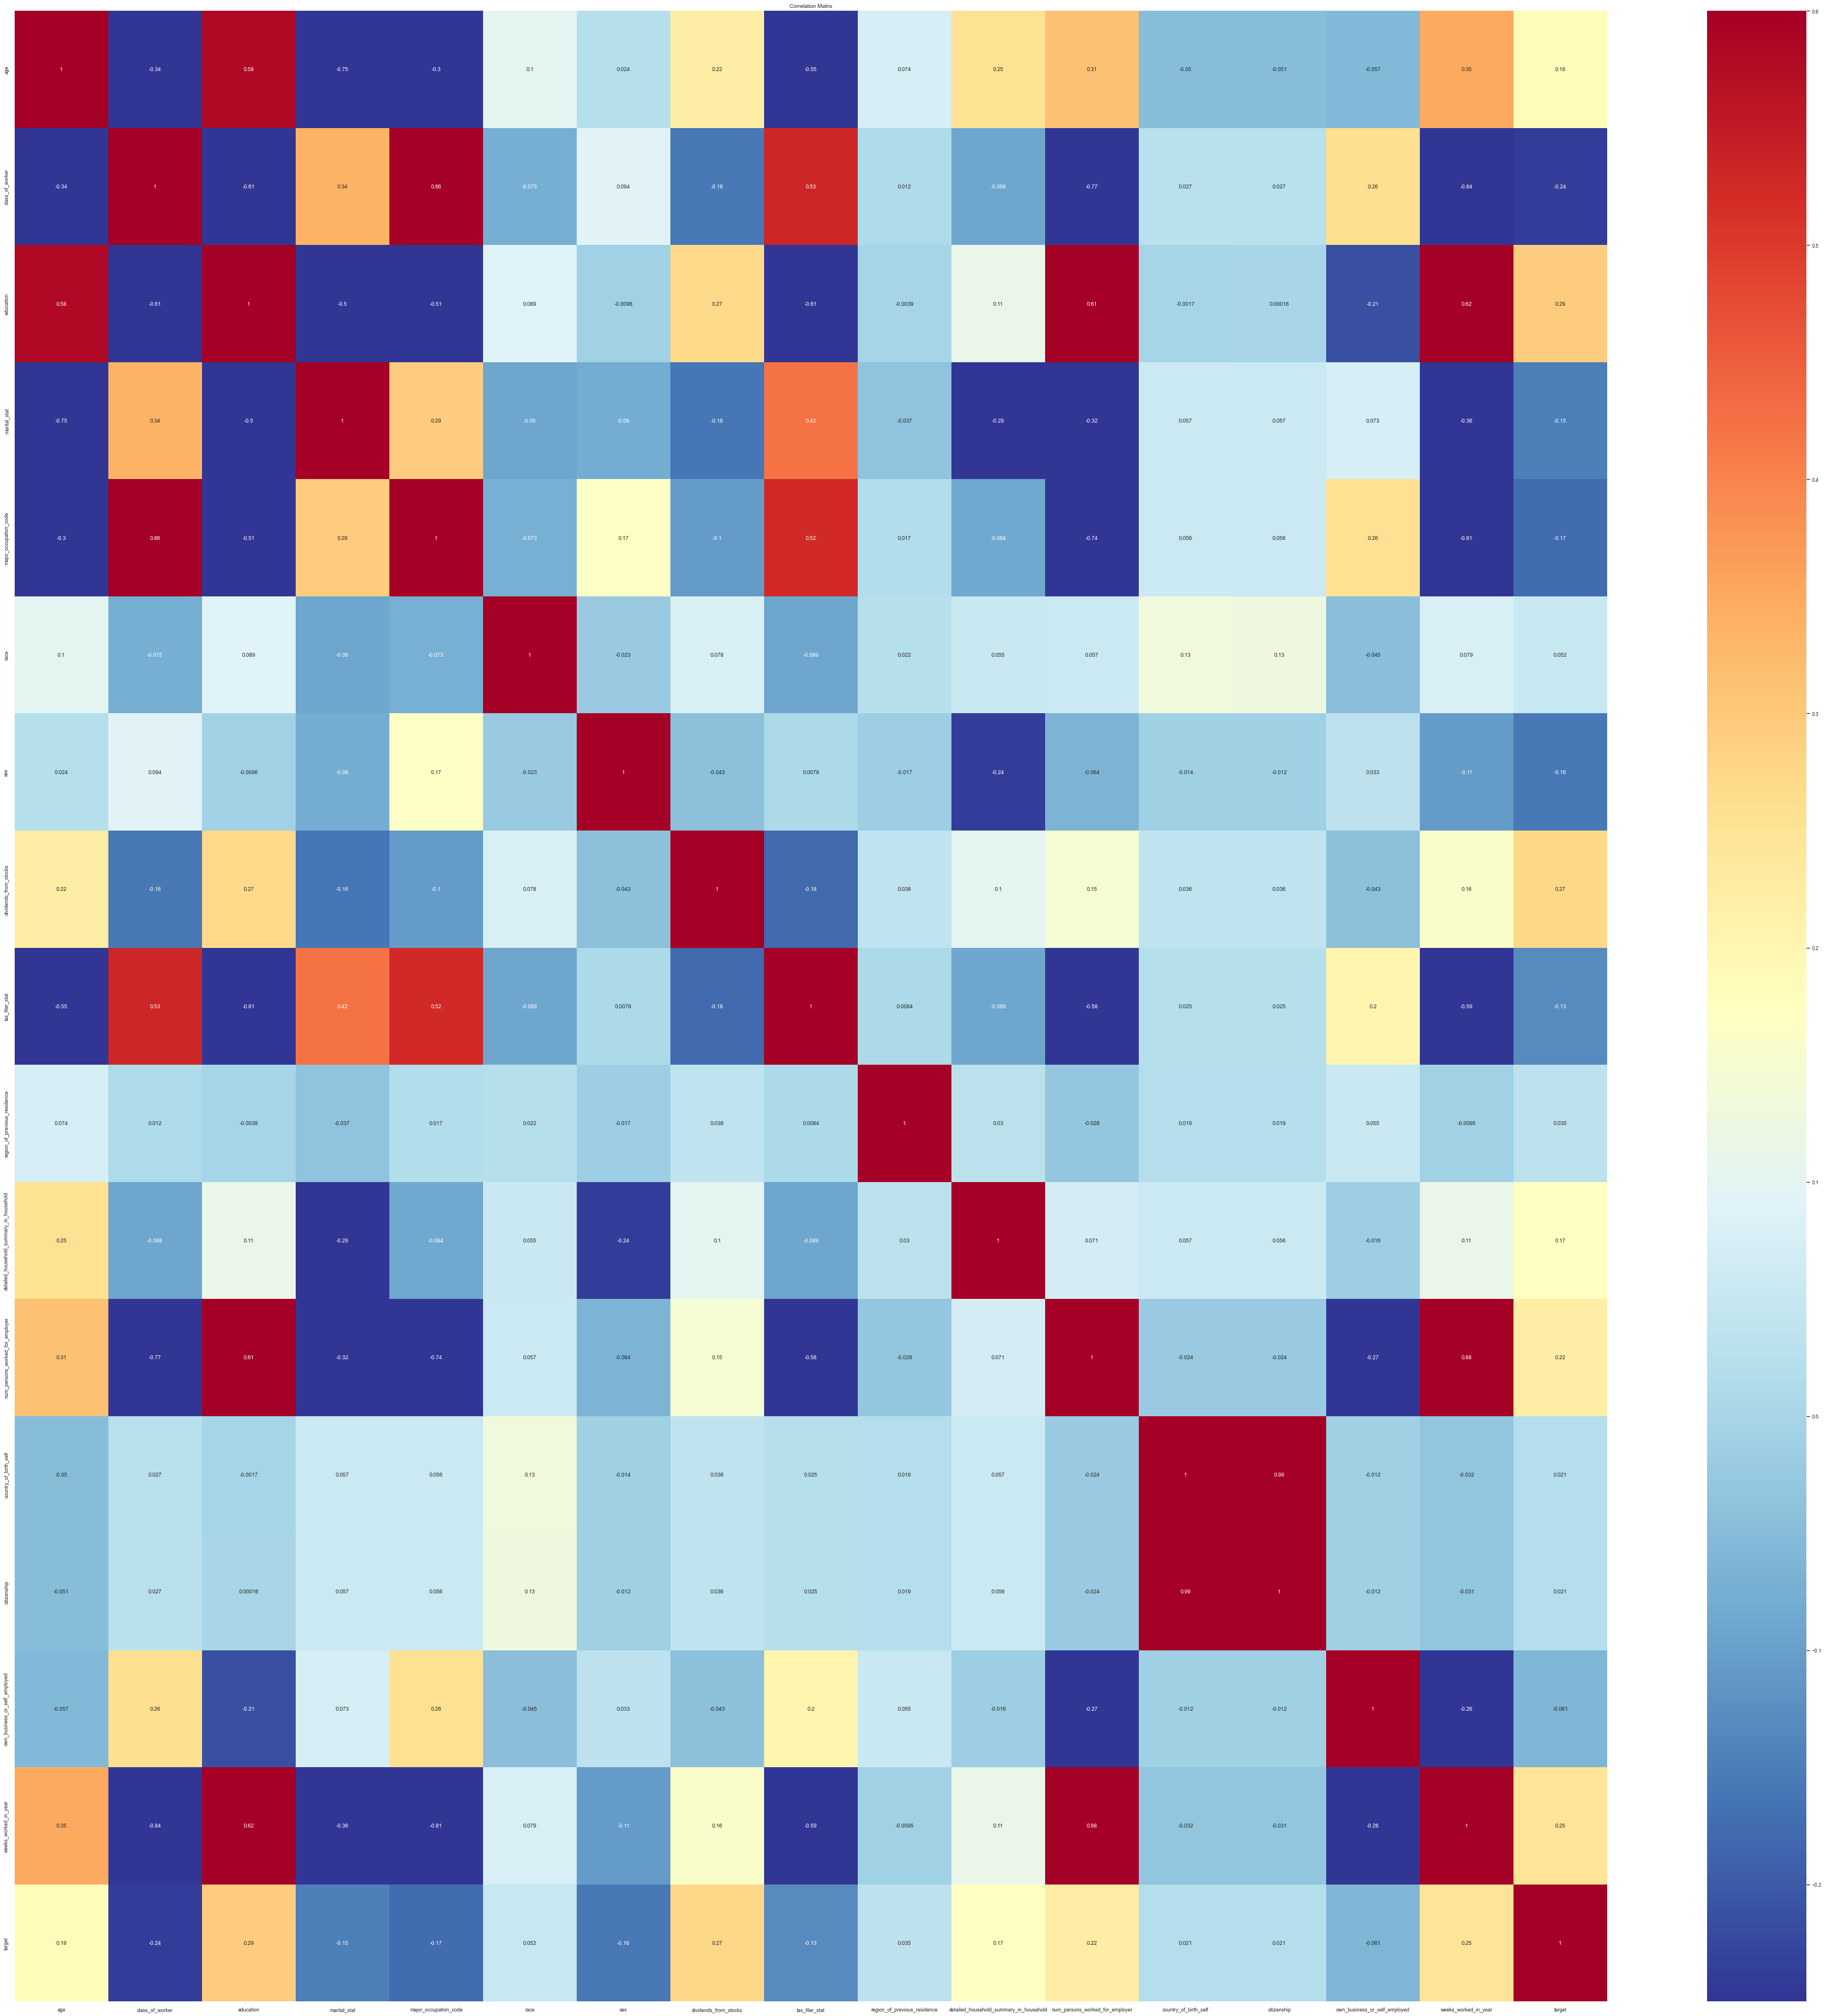

In [151]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [152]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 7
The number of features remaining: 9


In [153]:
del_features

array(['citizenship', 'class_of_worker', 'major_occupation_code',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U31')

In [154]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 9


In [155]:
sorted(count_features)

['age',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [156]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [157]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [158]:
X_te2.isna().sum()

age                                        0
education                                  4
marital_stat                               0
race                                       2
sex                                        1
dividends_from_stocks                      0
tax_filer_stat                             2
region_of_previous_residence               3
detailed_household_summary_in_household    2
country_of_birth_self                      1
citizenship                                0
own_business_or_self_employed              1
weeks_worked_in_year                       0
dtype: int64

In [159]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Black',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Not in universe',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Private',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'Trinadadad&Tobago',
 'Trinadadadad&Tobago',
 'U S (Guam USVI etc)',
 'U-Salvador',
 'United-States',
 'Vietnam',
 'Yugoslavia',
 'the Mexico']

In [160]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [161]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0,

In [162]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 266 ms
Wall time: 222 ms


In [163]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.810 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.794 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.820 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.810 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.801 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.820 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.804 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.831 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.827 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.809 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.826 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [164]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8205610050767754
LogisticRegression(C=0.01, solver='saga')


In [165]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [166]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [167]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test           0.792919   

     Recall  Precision   ROC_AUC  
0  0.807487   0.194964  0.792919

In [168]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.835986   

     Recall  Precision   ROC_AUC  
0  0.899471   0.210006  0.835986

In [169]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 297 ms
Wall time: 286 ms


In [170]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.828 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.814 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.829 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.808 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.838 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.819 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.836 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.831 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.809 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.837 total time=   0.5s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.837 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.820 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.839 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.834 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.811 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.837 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.820 total time=   3.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.839 total time=   2.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.834 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.811 total time=   3.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.837 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.820 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.839 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.834 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.811 total time=   2.3s
CPU times: total: 46.6 s
Wall time: 48.3 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [171]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8284105847607929
LogisticRegression(C=0.1, solver='saga')


In [172]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [173]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [174]:
res_test22

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl real features  Synth test           0.804228   

     Recall  Precision   ROC_AUC  
0  0.823529   0.202899  0.804228

In [175]:
res_test_real22

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression GPT2xl real features  Real test           0.843311  0.912698   

   Precision   ROC_AUC  
0    0.21349  0.843311

## Cerebras classification

### Data preprocessing 

In [176]:
synt_data = synt_data_cerebras.copy()

In [177]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [178]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [179]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [180]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [181]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Bachelors degree(BA AB BS)' '10th grade' 'Children'
 'High school graduate' '7th and 8th grade' 'Some college but no degree'
 'Masters degree(MA MS MEng MEd MSW MBA)' '5th or 6th grade'
 '1st 2nd 3rd or 4th grade' '11th grade' '9th grade'
 'Associates degree-occup /vocational' '12th grade no diploma'
 'Doctorate degree(PhD EdD)' 'Associates degree-academic program'
 'Prof school degree (MD DDS DVM LLB JD)' '14th and 8th grade'
 'Less than 1st grade' '0' '3rd or 4th grade' '13th and 8th grade'
 'Precision production craft & repair' 'Professional specialty'
 '4th or 6th grade' '15th or 6th grade' 'Married-civilian spouse present'
 'Abroad' '8th grade' 'Joint both under 65' '6th or 8th grade' 'Sales'
 'Child under 18 never married' '2nd 3rd or 4th grade'
 '- Some college but no degree' 'Local government' '6th or 7th grade'
 'Other'] 37


In [182]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [183]:
to_encode_synt = to_encode.copy() 

In [184]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [185]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [186]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  7
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [187]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [188]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.326499   0.591489   
class_of_worker                         -0.326499         1.000000  -0.604495   
education                                0.591489        -0.604495   1.000000   
marital_stat                            -0.760268         0.337807  -0.505212   
major_occupation_code                   -0.286846         0.860077  -0.491761   
race                                     0.084129        -0.083133   0.093115   
sex                                      0.032853         0.077653   0.002057   
dividends_from_stocks                    0.213820        -0.164720   0.275736   
tax_filer_stat                          -0.540567         0.539558  -0.606043   
region_of_previous_residence             0.072700         0.024377  -0.007949   
detailed_household_summary_in_household  0.231110        -0.072306   0.089446   
num_persons_worked_for_employer          0.301961        -0.769173   0.605161   
country_of_birth_self                   -0.051948         0.024204  -0.010162   
citizenship                             -0.051387         0.023476  -0.008307   
own_business_or_self_employed           -0.052016         0.256696  -0.212655   
weeks_worked_in_year                     0.343194        -0.842057   0.624235   
target                                   0.178882        -0.235415   0.287380   

                                         marital_stat  major_occupation_code  \
age                                         -0.760268              -0.286846   
class_of_worker                              0.337807               0.860077   
education                                   -0.505212              -0.491761   
marital_stat                                 1.000000               0.303344   
major_occupation_code                        0.303344               1.000000   
race                                        -0.071741              -0.067841   
sex                                         -0.087819               0.128389   
dividends_from_stocks                       -0.164235              -0.097955   
tax_filer_stat                               0.428767               0.536151   
region_of_previous_residence                -0.036745               0.034711   
detailed_household_summary_in_household     -0.258619              -0.074601   
num_persons_worked_for_employer             -0.319009              -0.743943   
country_of_birth_self                        0.058354               0.053662   
citizenship                                  0.057264               0.052970   
own_business_or_self_employed                0.072436               0.241282   
weeks_worked_in_year                        -0.364598              -0.813042   
target                                      -0.150971              -0.160373   

                                             race       sex  \
age                                      0.084129  0.032853   
class_of_worker                         -0.083133  0.077653   
education                                0.093115  0.002057   
marital_stat                            -0.071741 -0.087819   
major_occupation_code                   -0.067841  0.128389   
race                                     1.000000 -0.025218   
sex                                     -0.025218  1.000000   
dividends_from_stocks                    0.084923 -0.029047   
tax_filer_stat                          -0.093478 -0.016290   
region_of_previous_residence             0.031056 -0.005767   
detailed_household_summary_in_household  0.042650 -0.245172   
num_persons_worked_for_employer          0.062760 -0.053271   
country_of_birth_self                    0.139754 -0.007586   
citizenship                              0.134015 -0.007573   
own_business_or_self_employed           -0.043366  0.015387   
weeks_worked_in_year                     0.088567 -0.084027   
target                                   0.055889 -0.165077   

           

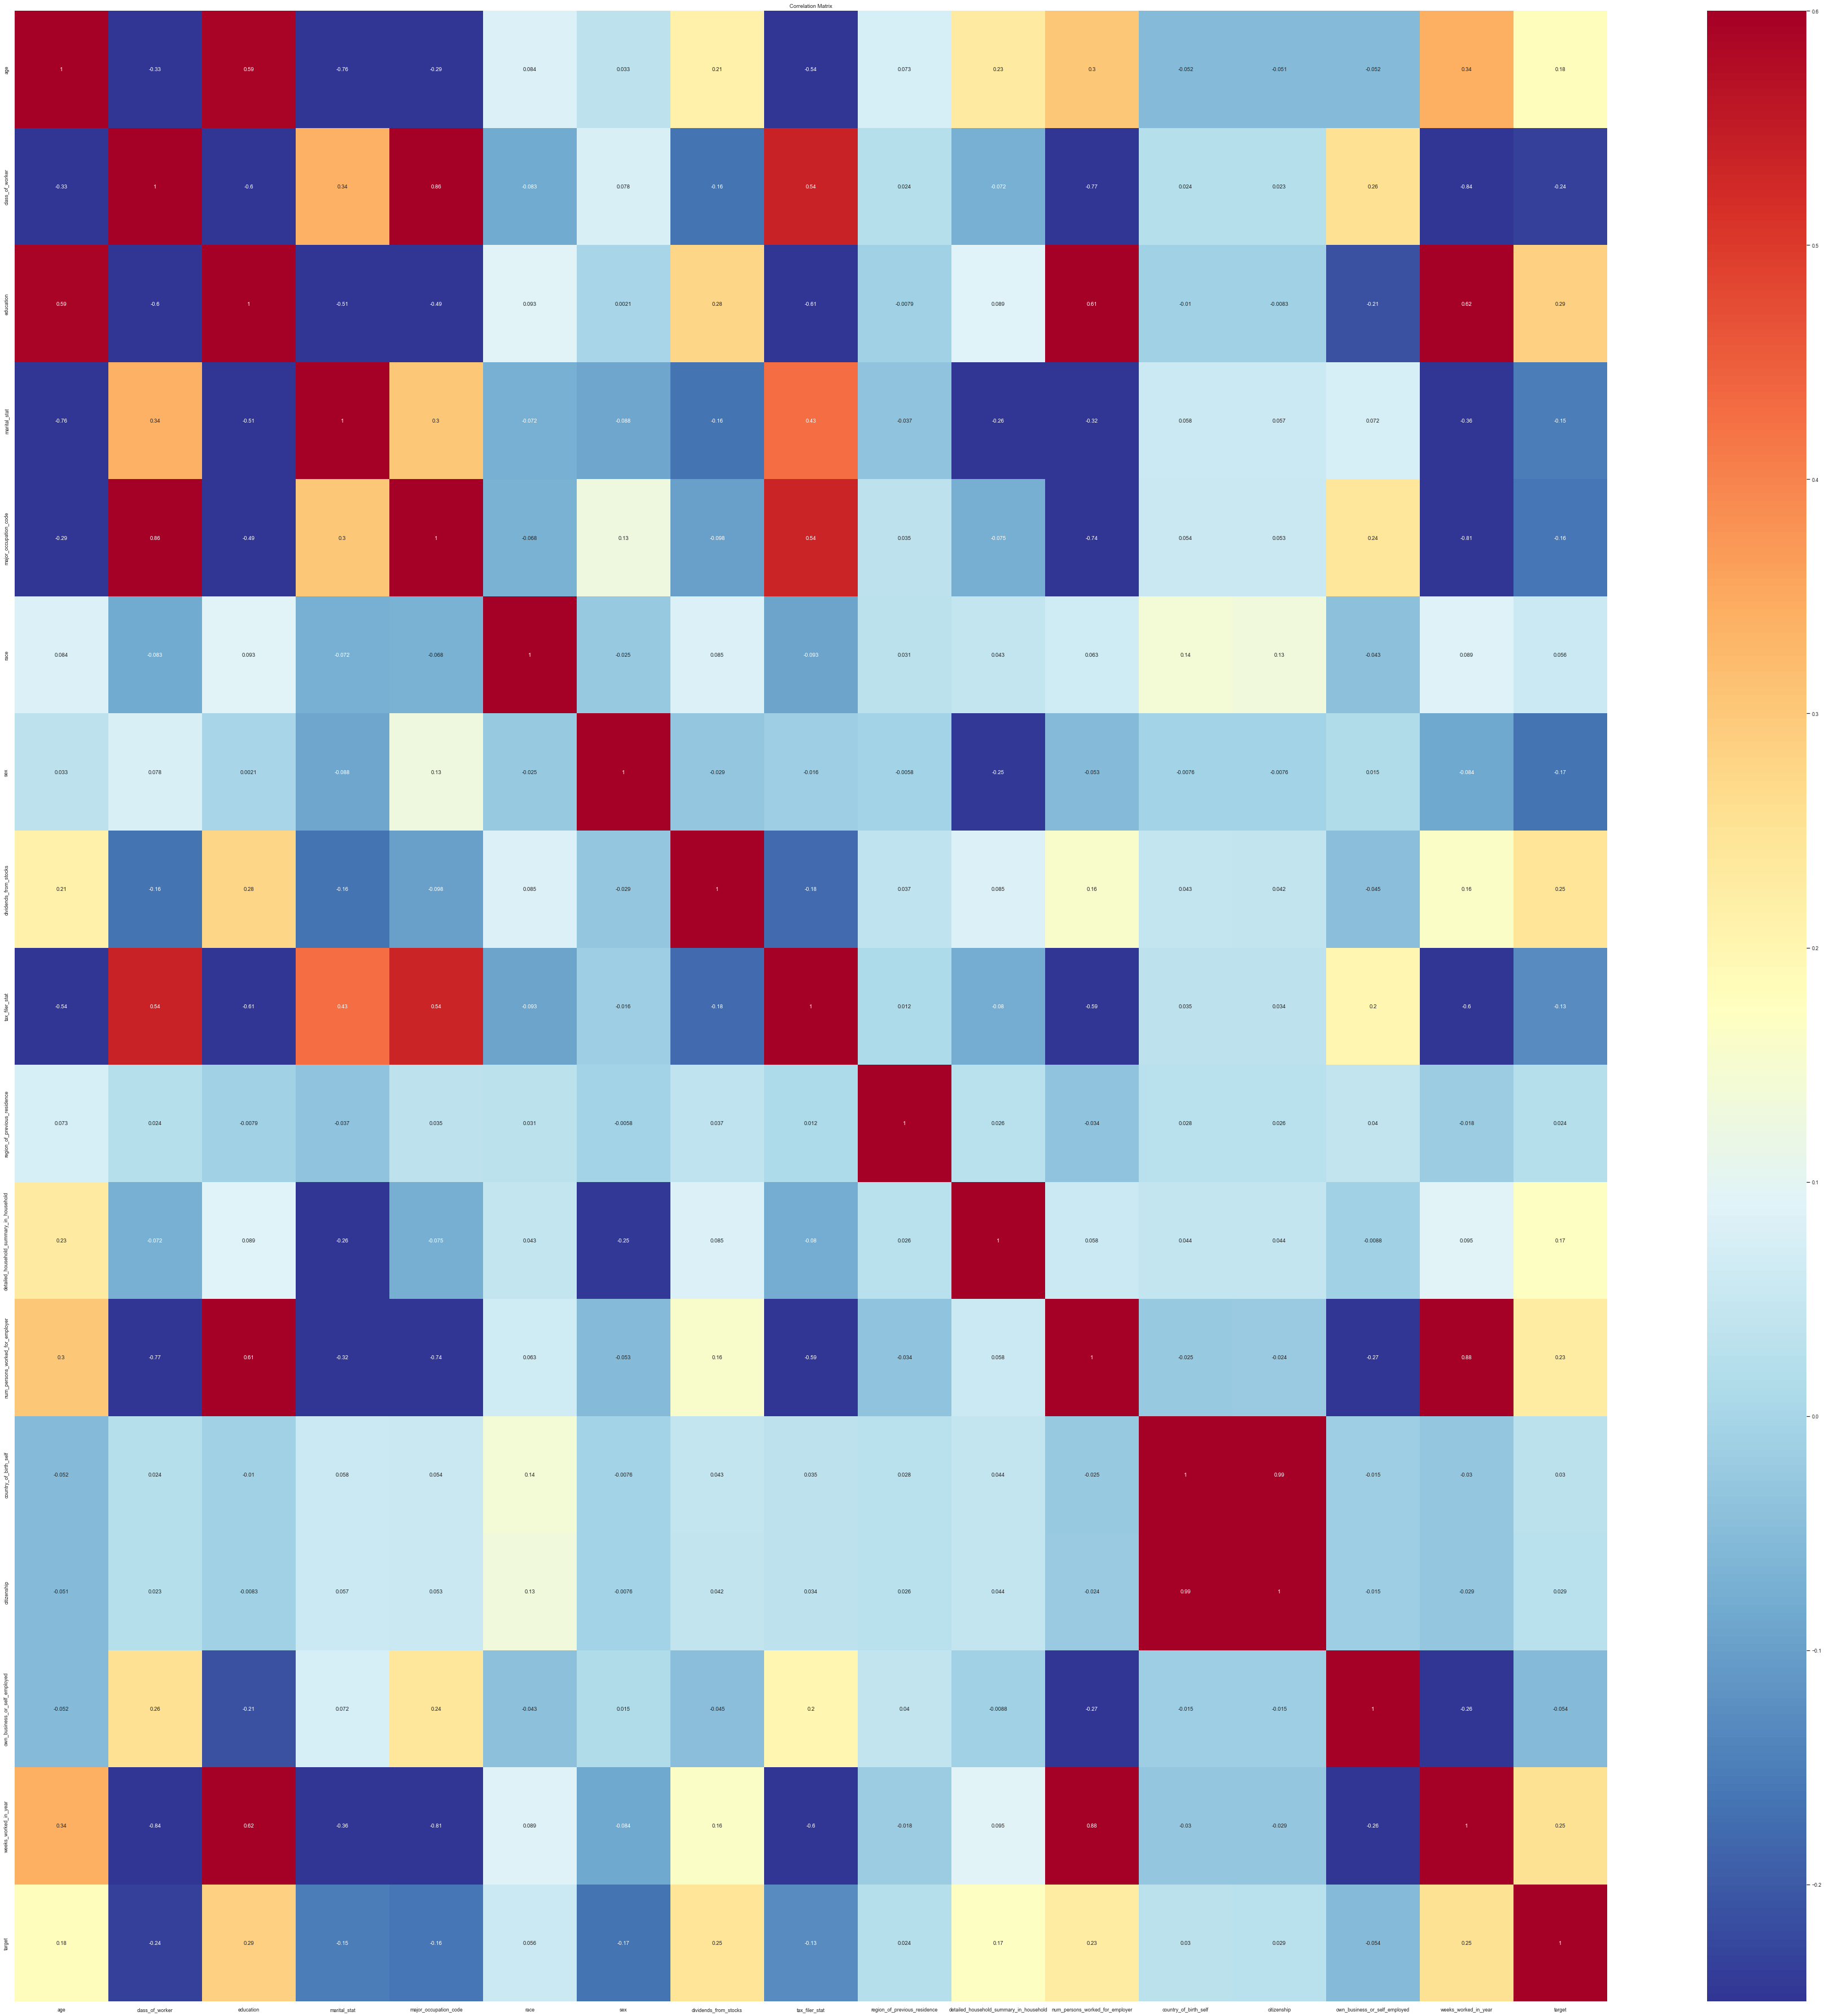

In [189]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [190]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 7
The number of features remaining: 9


In [191]:
del_features

array(['citizenship', 'class_of_worker', 'major_occupation_code',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U31')

In [192]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 9


In [193]:
sorted(count_features)

['age',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [194]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [195]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [196]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                 0
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      0
country_of_birth_self                       93
citizenship                                412
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [197]:
sorted(synt_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S',
 'Foreign born- Private',
 'Foreign born- U S citizen by naturalization',
 'Foreign born-not a citizen of U S',
 'Native- Born abroad of American Parent(s)',
 'Native- Born class_of_worker',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States',
 'Native- Born num_persons_worked_for_employer',
 'Never Foreign born- Not a citizen of U S',
 'Some college but no degree']

In [198]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [199]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0,

In [200]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 219 ms
Wall time: 273 ms


In [201]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.797 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.821 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.816 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.810 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.815 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.806 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.829 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.821 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.820 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.822 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.806 total time=   0.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [202]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8195308691527563
LogisticRegression(C=0.001, solver='saga')


In [203]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [204]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [205]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test           0.812209   

     Recall  Precision   ROC_AUC  
0  0.865079   0.194643  0.812209

In [206]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.825459   

     Recall  Precision   ROC_AUC  
0  0.886243   0.202051  0.825459

In [207]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 312 ms
Wall time: 355 ms


In [208]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.819 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.821 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.816 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.831 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.828 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.825 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.821 total time=   0.3s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.825 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.834 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.833 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.828 total time=   0.6s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.827 total time=   2.3s
[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.824 total time=   2.0s
[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.828 total time=   1.6s
[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.834 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.833 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.826 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.824 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.827 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.834 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.833 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.826 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.824 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.828 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.834 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.833 total time=   2.1s
CPU times: total: 39.1 s
Wall time: 39.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [209]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8293584185154694
LogisticRegression(C=0.01, solver='saga')


In [210]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [211]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [212]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.815889   

     Recall  Precision   ROC_AUC  
0  0.857143   0.203646  0.815889

In [213]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.843778   

     Recall  Precision   ROC_AUC  
0  0.907407   0.217226  0.843778

## Phi1.5 classification

### Data preprocessing 

In [214]:
synt_data = synt_data_phi.copy()

In [215]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [216]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [217]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['50000+.' '- 50000.'] 2


In [218]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [219]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Bachelors degree(BA AB BS)' 'Children' 'High school graduate'
 '9th grade' 'Some college but no degree'
 'Associates degree-occup /vocational' '7th and 8th grade' '11th grade'
 'Prof school degree (MD DDS DVM LLB JD)' 'Nonrelative of householder'
 '5th or 6th grade' 'Masters degree(MA MS MEng MEd MSW MBA)' '10th grade'
 '12th grade no diploma' 'Associates degree-academic program'
 '1st 2nd 3rd or 4th grade' 'Doctorate degree(PhD EdD)'
 'Less than 1st grade' '8th grade' '- 50000.' 'Not in universe'
 'Without pay' '14th grade' 'Child under 18 never married' '0' '6th grade'
 '15th grade' 'Sales' '3rd or 4th grade' '4th or 6th grade'
 'Never married' '2nd or 3rd grade' 'Private college but no degree'
 'Self-employed-not incorporated' 'Associates degree-not diploma'] 35


In [220]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [221]:
to_encode_synt = to_encode.copy() 

In [222]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

In [223]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [224]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  8
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [225]:
#X_tr.fillna(0,inplace=True)

In [226]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                  float64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [227]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.308711   0.563985   
class_of_worker                         -0.308711         1.000000  -0.597059   
education                                0.563985        -0.597059   1.000000   
marital_stat                            -0.745101         0.316642  -0.476732   
major_occupation_code                   -0.267855         0.852511  -0.487132   
race                                     0.084269        -0.062735   0.085021   
sex                                      0.028090         0.064191   0.007879   
dividends_from_stocks                    0.218182        -0.139591   0.271884   
tax_filer_stat                          -0.531808         0.523343  -0.594193   
region_of_previous_residence             0.087424         0.006956   0.002316   
detailed_household_summary_in_household  0.244363        -0.076681   0.083362   
num_persons_worked_for_employer          0.287001        -0.762879   0.588565   
country_of_birth_self                   -0.060986         0.039441  -0.013546   
citizenship                             -0.062023         0.040303  -0.011883   
own_business_or_self_employed           -0.041148         0.249183  -0.204164   
weeks_worked_in_year                     0.326915        -0.832449   0.605848   
target                                   0.185448        -0.187681   0.248148   

                                         marital_stat  major_occupation_code  \
age                                         -0.745101              -0.267855   
class_of_worker                              0.316642               0.852511   
education                                   -0.476732              -0.487132   
marital_stat                                 1.000000               0.282216   
major_occupation_code                        0.282216               1.000000   
race                                        -0.076876              -0.058636   
sex                                         -0.090856               0.142638   
dividends_from_stocks                       -0.158073              -0.080669   
tax_filer_stat                               0.396841               0.514317   
region_of_previous_residence                -0.042478               0.023507   
detailed_household_summary_in_household     -0.271710              -0.085898   
num_persons_worked_for_employer             -0.302389              -0.733624   
country_of_birth_self                        0.068181               0.070528   
citizenship                                  0.069510               0.070948   
own_business_or_self_employed                0.056986               0.244009   
weeks_worked_in_year                        -0.345028              -0.799117   
target                                      -0.137206              -0.133110   

                                             race       sex  \
age                                      0.084269  0.028090   
class_of_worker                         -0.062735  0.064191   
education                                0.085021  0.007879   
marital_stat                            -0.076876 -0.090856   
major_occupation_code                   -0.058636  0.142638   
race                                     1.000000 -0.027216   
sex                                     -0.027216  1.000000   
dividends_from_stocks                    0.064450 -0.035040   
tax_filer_stat                          -0.078720 -0.005514   
region_of_previous_residence             0.035379 -0.005690   
detailed_household_summary_in_household  0.043551 -0.243320   
num_persons_worked_for_employer          0.050323 -0.051588   
country_of_birth_self                    0.144817 -0.007871   
citizenship                              0.137452 -0.007623   
own_business_or_self_employed           -0.033949  0.013865   
weeks_worked_in_year                     0.072955 -0.087067   
target                                   0.050847 -0.138194   

           

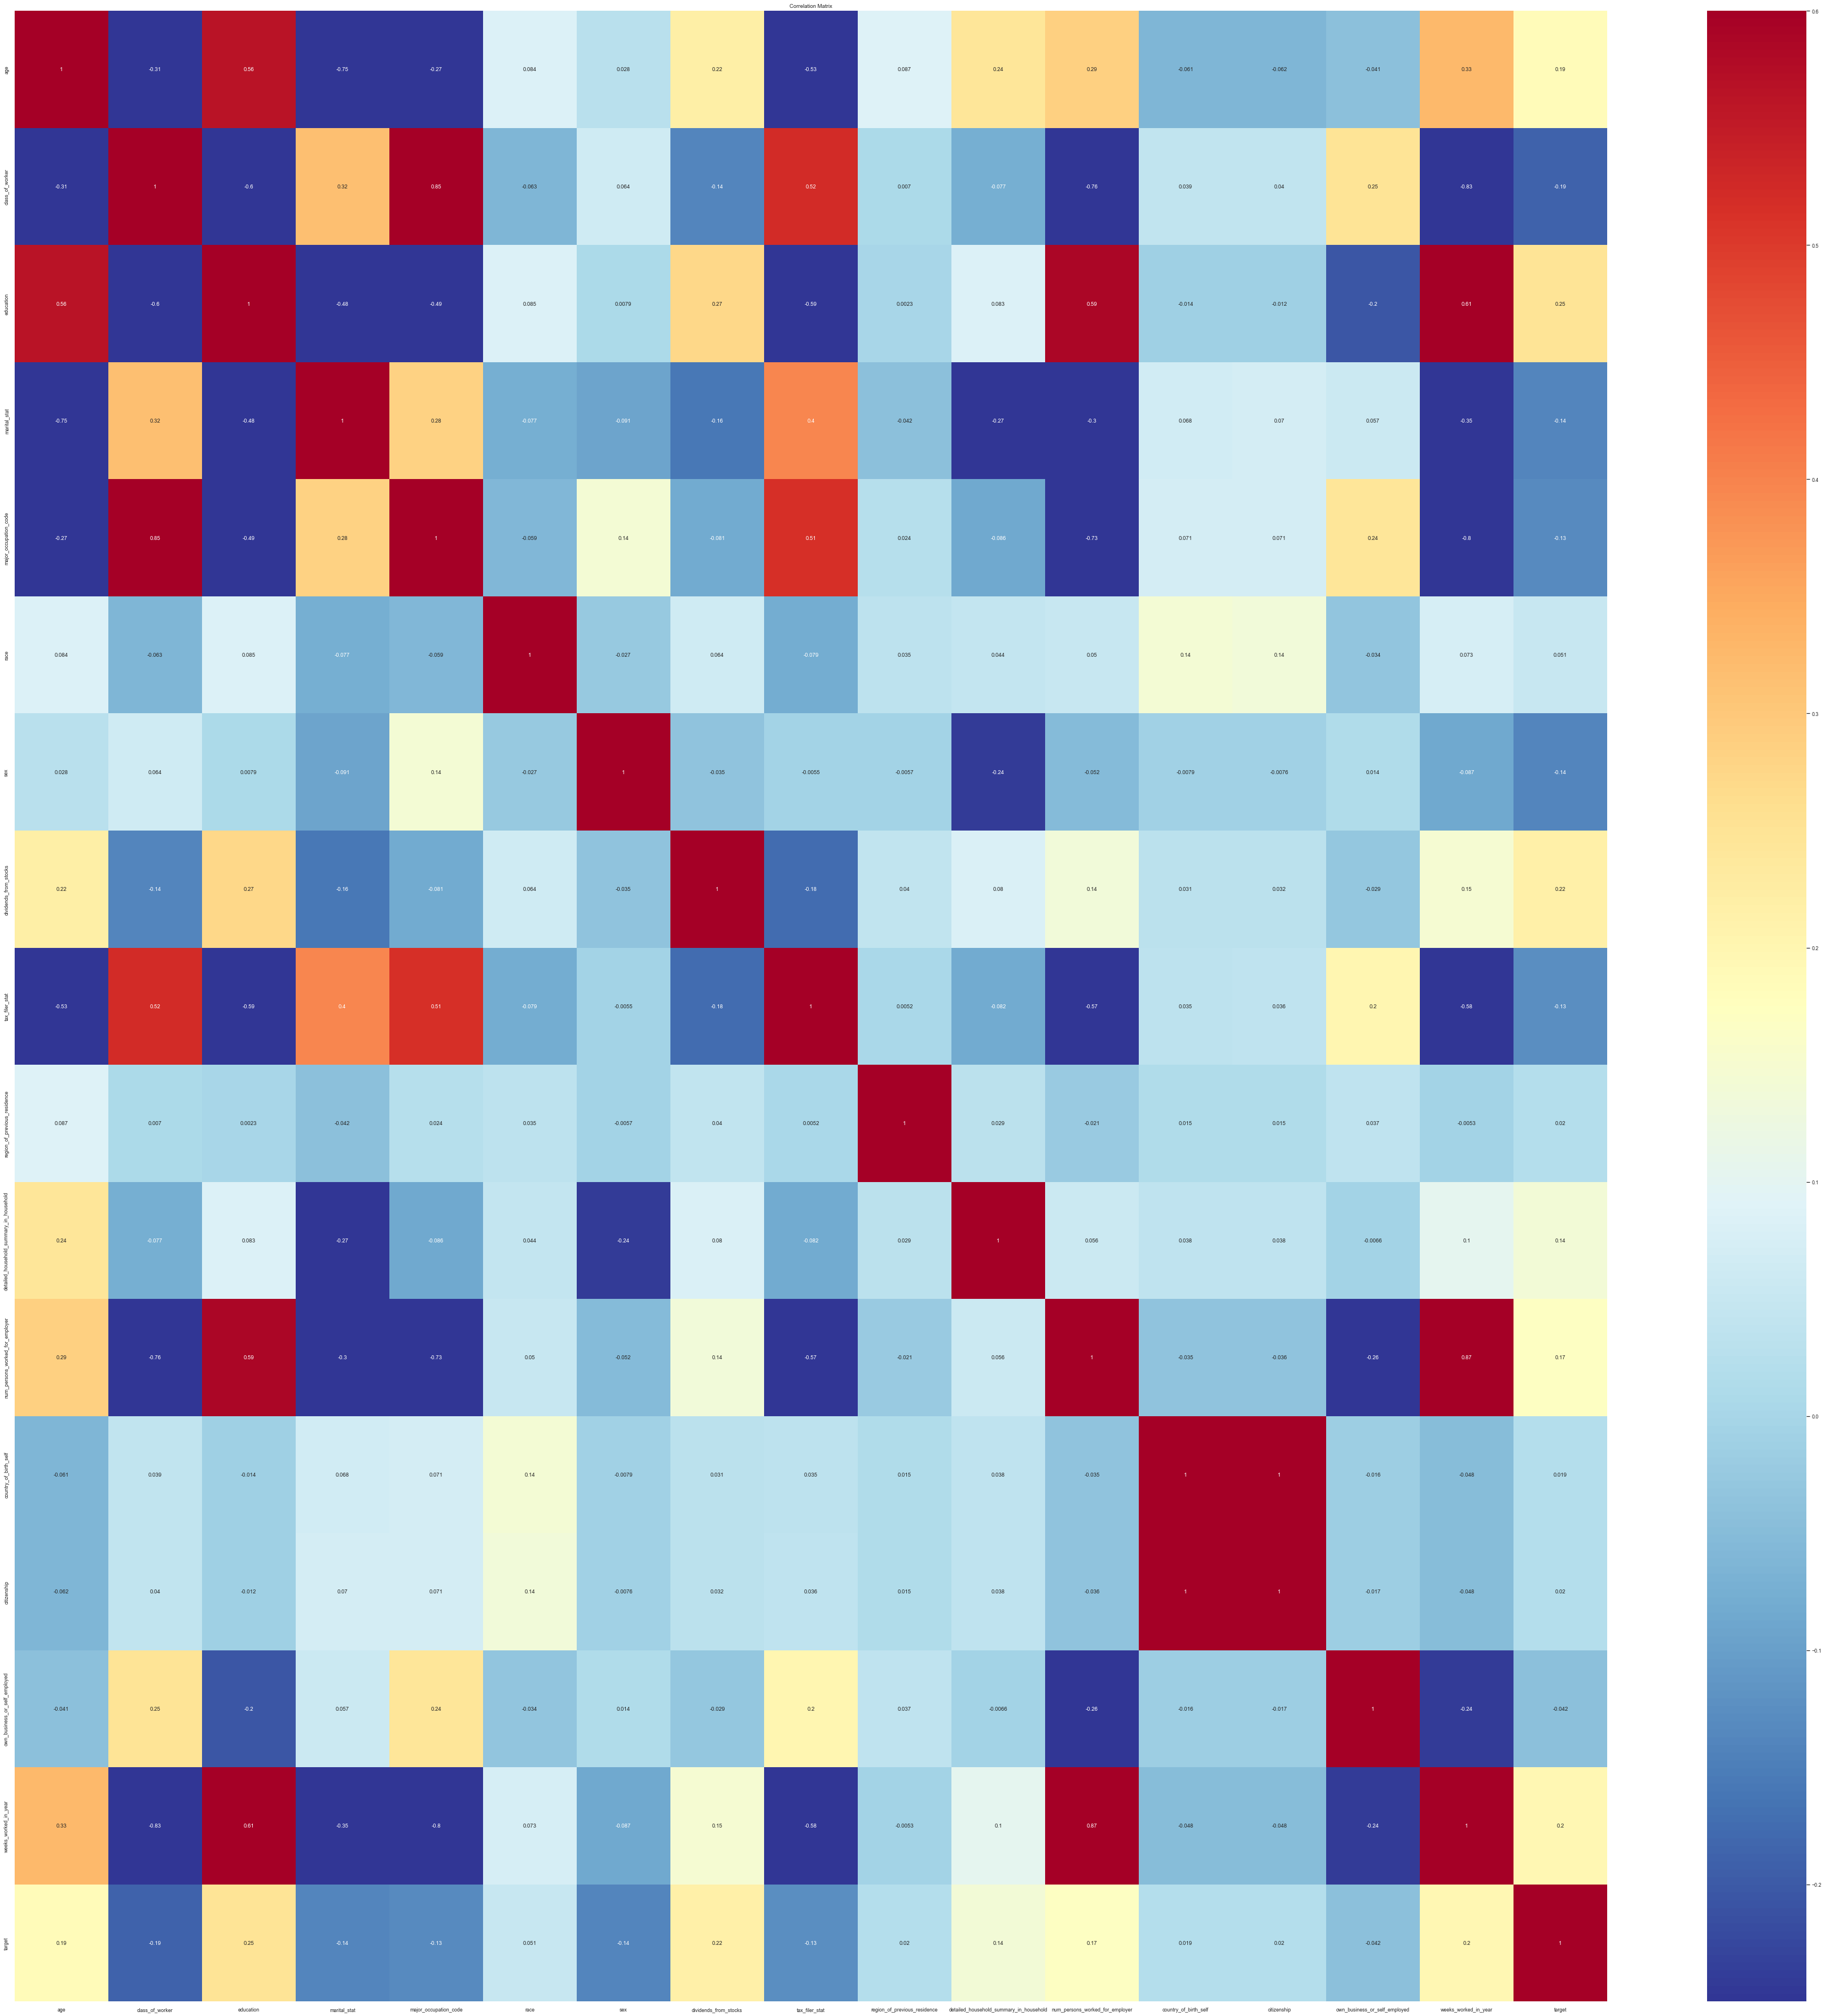

In [228]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [229]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.6:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 6
The number of features remaining: 10


In [230]:
del_features

array(['class_of_worker', 'country_of_birth_self',
       'major_occupation_code', 'marital_stat',
       'num_persons_worked_for_employer', 'weeks_worked_in_year'],
      dtype='<U31')

In [231]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 10


In [232]:
sorted(count_features)

['age',
 'citizenship',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [233]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [234]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [235]:
X_te2.isna().sum()

age                                        0
education                                  1
marital_stat                               1
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             2
region_of_previous_residence               1
detailed_household_summary_in_household    3
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [236]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Asian or Pacific Islander',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Not in universe',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Technicians and related support',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia',
 'the United-States']

In [237]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [238]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\768061667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0,

In [239]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 328 ms
Wall time: 287 ms


In [240]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.762 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.756 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.783 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.768 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.767 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.765 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.761 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.789 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.776 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.767 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.765 total time=   0.1s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [241]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7729520067629705
LogisticRegression(C=0.1, solver='saga')


In [242]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [243]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [244]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test            0.76948   

     Recall  Precision  ROC_AUC  
0  0.805851    0.16796  0.76948

In [245]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test           0.818199   

     Recall  Precision   ROC_AUC  
0  0.899471   0.186916  0.818199

In [246]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 359 ms
Wall time: 350 ms


In [247]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.766 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.764 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.768 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.771 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.772 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.774 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.764 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.776 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.776 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.780 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.777 total time=   1.0s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.778 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.762 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.777 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.777 total time=   2.2s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.783 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.778 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.763 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.777 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.777 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.783 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.778 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.763 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.777 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.777 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.783 total time=   2.2s
CPU times: total: 45.1 s
Wall time: 46.2 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [248]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7756208959040567
LogisticRegression(C=10, solver='saga')


In [249]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [250]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [251]:
res_test42

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 real features  Synth test            0.77142   

     Recall  Precision  ROC_AUC  
0  0.816489   0.166306  0.77142

In [252]:
res_test_real42

Model    Dataset  Balanced_accuracy   Recall  \
0  LogRegression Phi1.5 real features  Real test           0.827168  0.92328   

   Precision   ROC_AUC  
0   0.187534  0.827168

## Modelling result

In [253]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.631246   
0  LogRegression DistillGPT synthetic features   Real test           0.762397   
0       LogRegression DistillGPT real features  Synth test           0.633827   
0       LogRegression DistillGPT real features   Real test           0.771681   
0      LogRegression GPT2xl synthetic features  Synth test           0.792919   
0      LogRegression GPT2xl synthetic features   Real test           0.835986   
0           LogRegression GPT2xl real features  Synth test           0.804228   
0           LogRegression GPT2xl real features   Real test           0.843311   
0    LogRegression Cerebras synthetic features  Synth test           0.812209   
0    LogRegression Cerebras synthetic features   Real test           0.825459   
0         LogRegression Cerebras real features  Synth test           0.815889   
0         LogRegression Cerebras real features   Real test           0.843778   
0      LogRegression Phi1.5 synthetic features  Synth test           0.769480   
0      LogRegression Phi1.5 synthetic features   Real test           0.818199   
0           LogRegression Phi1.5 real features  Synth test           0.771420   
0           LogRegression Phi1.5 real features   Real test           0.827168   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.750656   0.094421  0.631246  
0  0.970899   0.127652  0.762397  
0  0.729659   0.096729  0.633827  
0  0.962963   0.133676  0.771681  
0  0.807487   0.194964  0.792919  
0  0.899471   0.210006  0.835986  
0  0.823529   0.202899  0.804228  
0  0.912698   0.213490  0.843311  
0  0.865079   0.194643  0.812209  
0  0.886243   0.202051  0.825459  
0  0.857143   0.203646  0.815889  
0  0.907407   0.217226  0.843778  
0  0.805851   0.167960  0.769480  
0  0.899471   0.186916  0.818199  
0  0.816489   0.166306  0.771420  
0  0.923280   0.187534  0.827168

In [254]:
model_results.to_csv('model_results_shortincome_temp1.0.csv')

# Privacy metrics

In [255]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [256]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

In [257]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [258]:
tgt_train = real_dataset.copy()

In [259]:
tgt_test = control_dataset.copy()

In [260]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [261]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [262]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [263]:
hmm_train = map_humming(hmm_train,hmm)

In [264]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [265]:
norm_weights

[90, 99999, 6, 52]

In [266]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [267]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [268]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [269]:
hmm_test = map_humming(hmm_test,hmm)

In [270]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [271]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

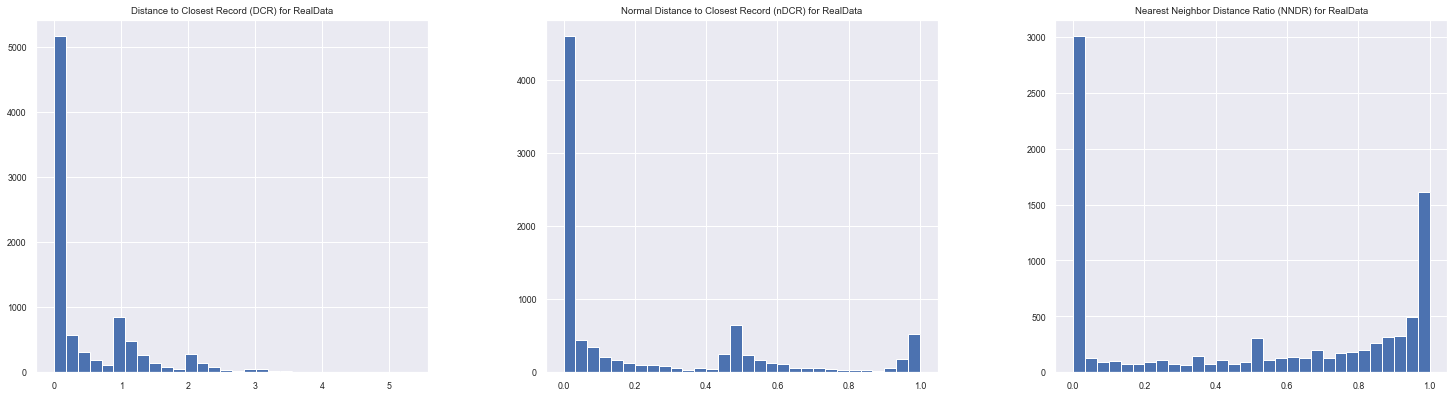

In [272]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [273]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [274]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [275]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [276]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [277]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_1032\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [278]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [279]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [280]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [281]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [282]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats 0.6464648554357422 0.3877632718065281 1.0 0.0 9000
nDCR stats 0.42215884551631483 0.37838811741837897 1.0 0.0 9000
DCR Bound 0.95 % = 3.0619679812182734


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

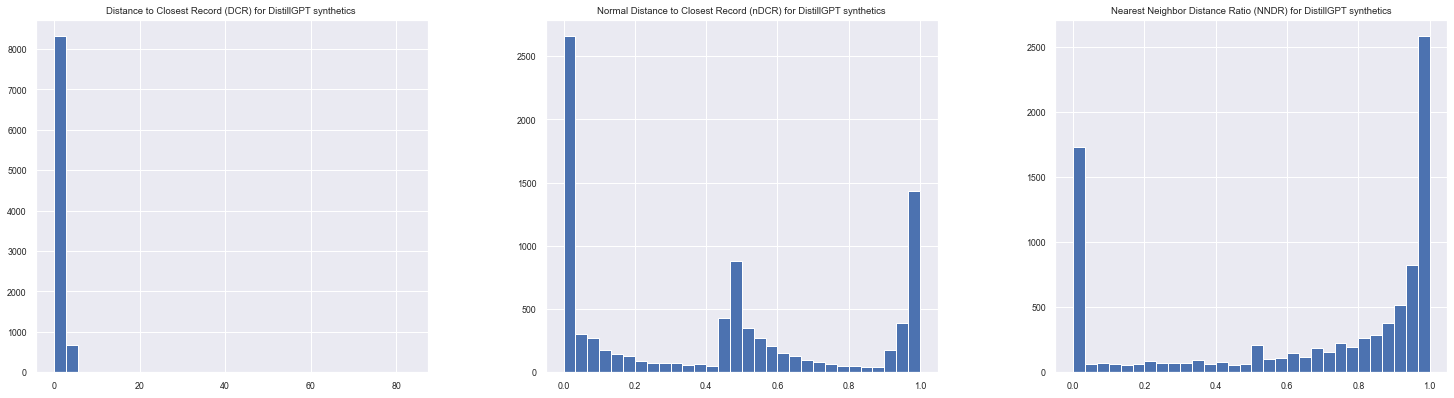

In [283]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

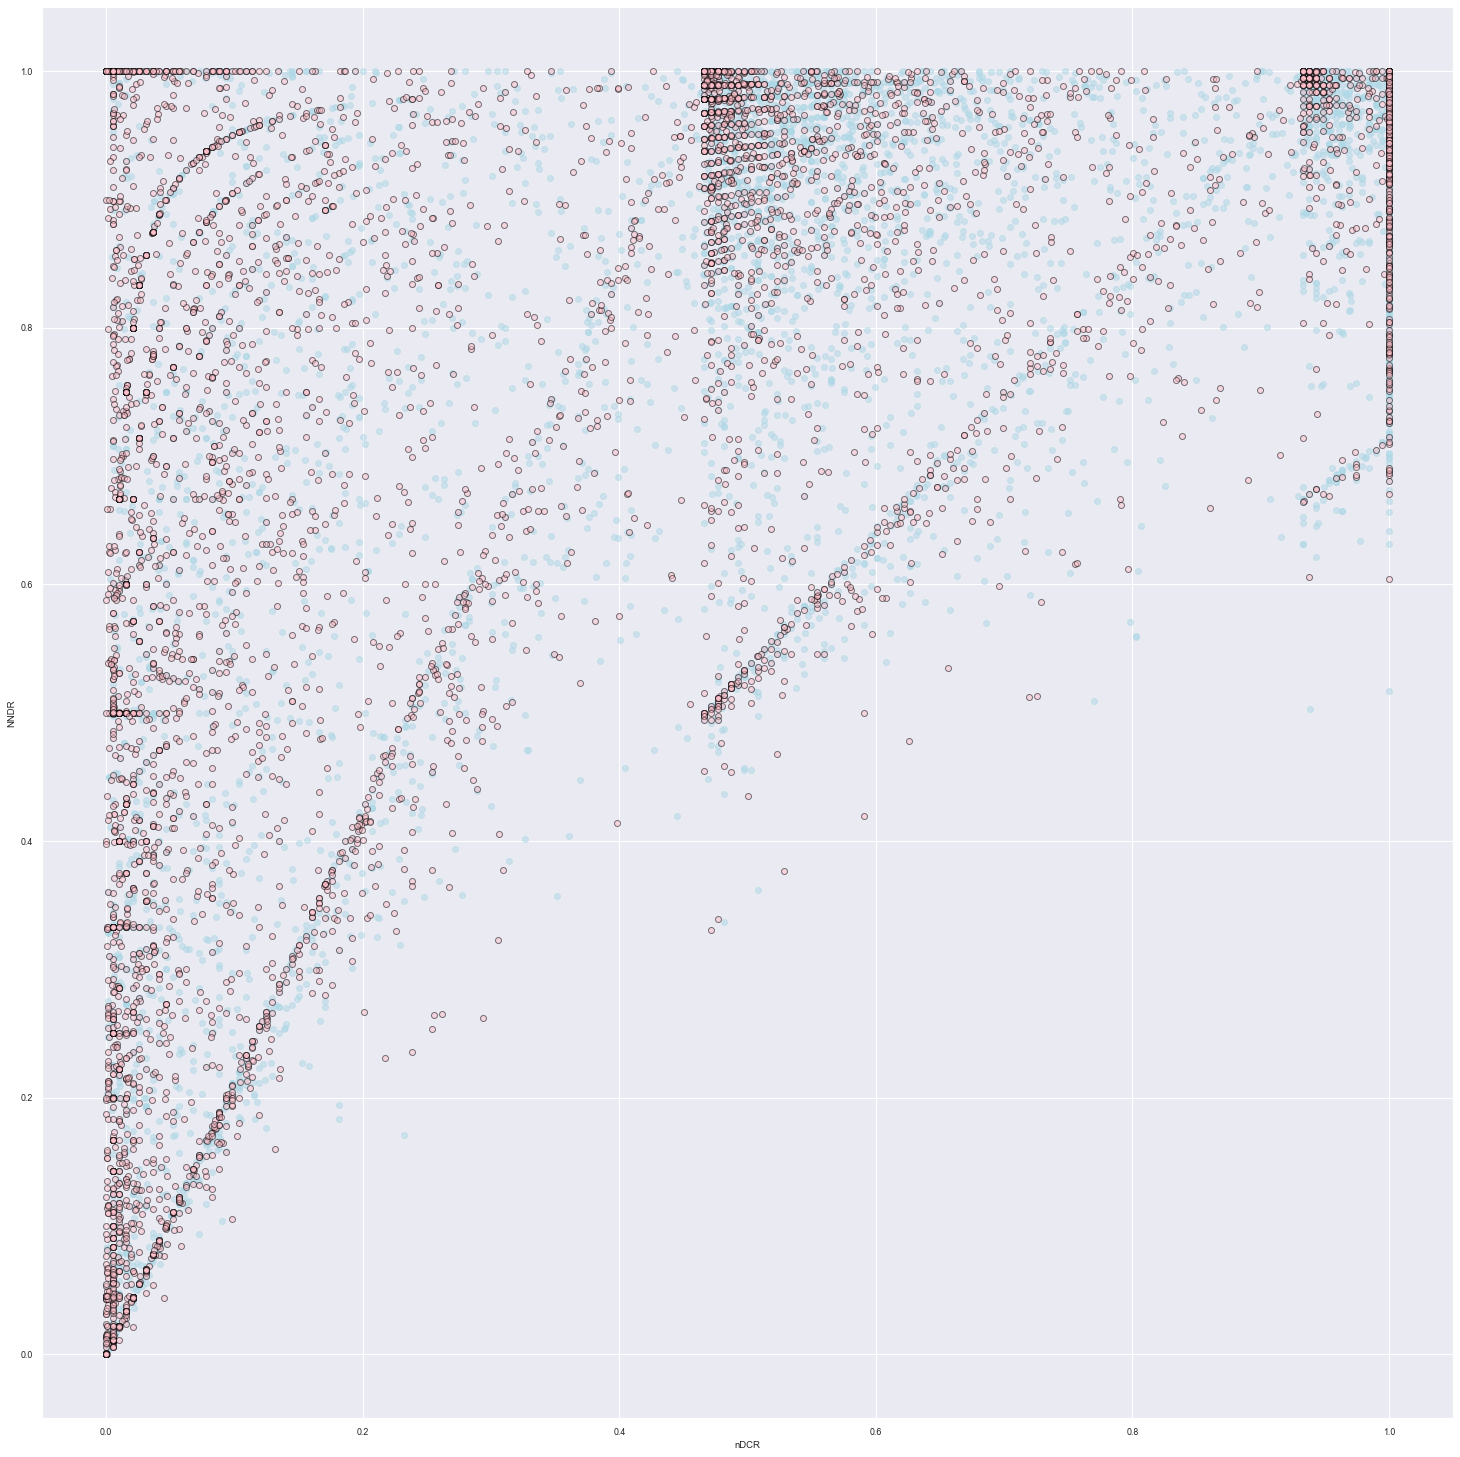

In [284]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [285]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

2.492433061699651

In [286]:
calc_nndr_ratio(nndr_real,nndr_synt1)

2.170130327580134

In [287]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=28403959.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=31237262.500000, p-value=0.000000
 Kolmogorov-Smirnov Test for nDCR: statistic=0.25255556, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.194000, p-value=0.000000


In [288]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [289]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [290]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [291]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [292]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [293]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.5004513623865025 0.4192833146314446 1.0 0.0 9000
nDCR stats 0.25924907203237035 0.33584862839195956 1.0 0.0 9000
DCR Bound 0.95 % = 2.31608144350674


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

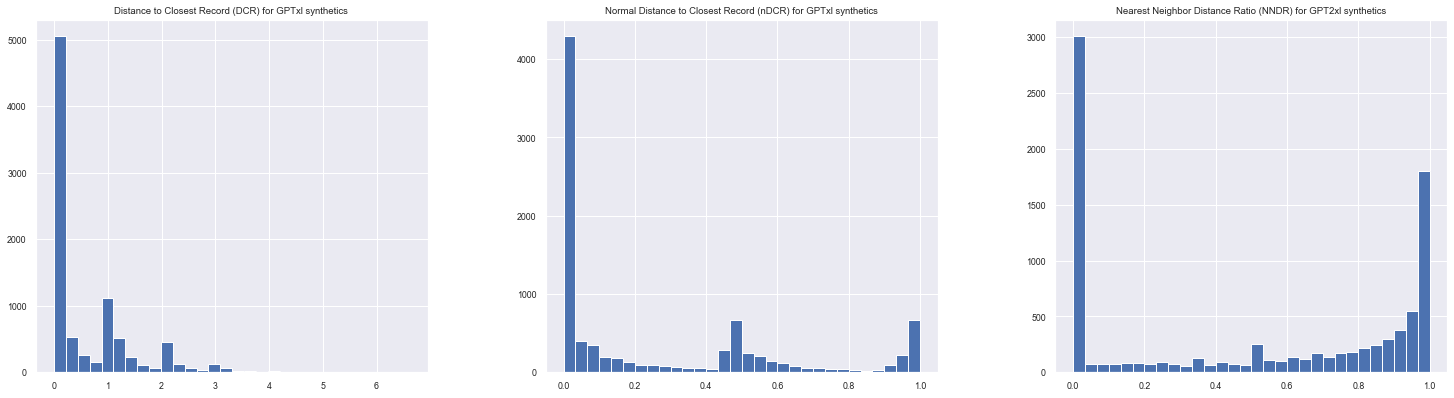

In [294]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

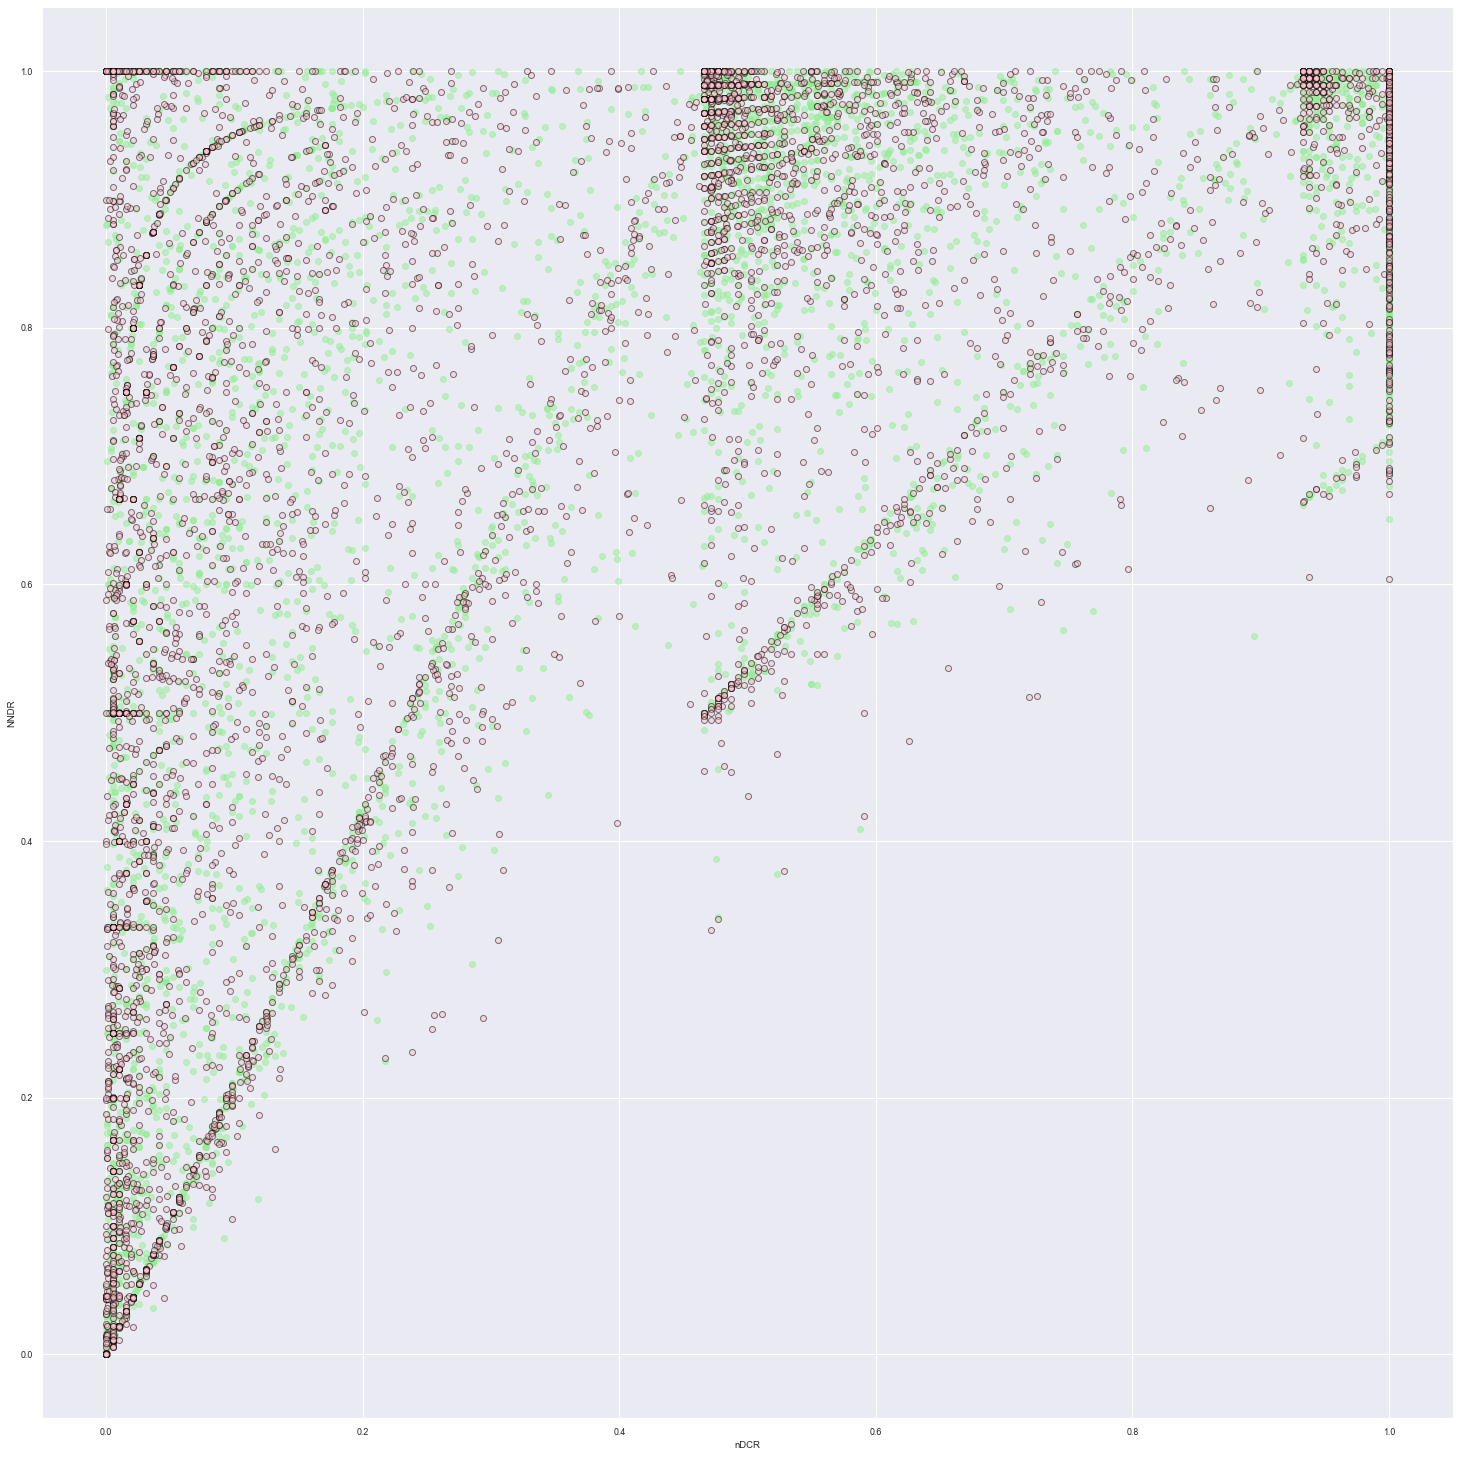

In [295]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [296]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

1.1448999046711152

In [297]:
calc_nndr_ratio(nndr_real,nndr_synt2)

1.1003500583430572

In [298]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=39048750.00000000, p-value=0.00002270
 Mann-Whitney U rank test for NNDR: statistic=39423152.500000, p-value=0.001669


 Kolmogorov-Smirnov Test for nDCR: statistic=0.04166667, p-value=0.00000033
 Kolmogorov-Smirnov Test for NNDR: statistic=0.035333, p-value=0.000026


In [299]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [300]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [301]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [302]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [303]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [304]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.4980378724980404 0.4183697905451569 1.0 0.0 9000
nDCR stats 0.2506999135336112 0.3311954158649967 1.0 0.0 9000
DCR Bound 0.95 % = 2.2591239316239293


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

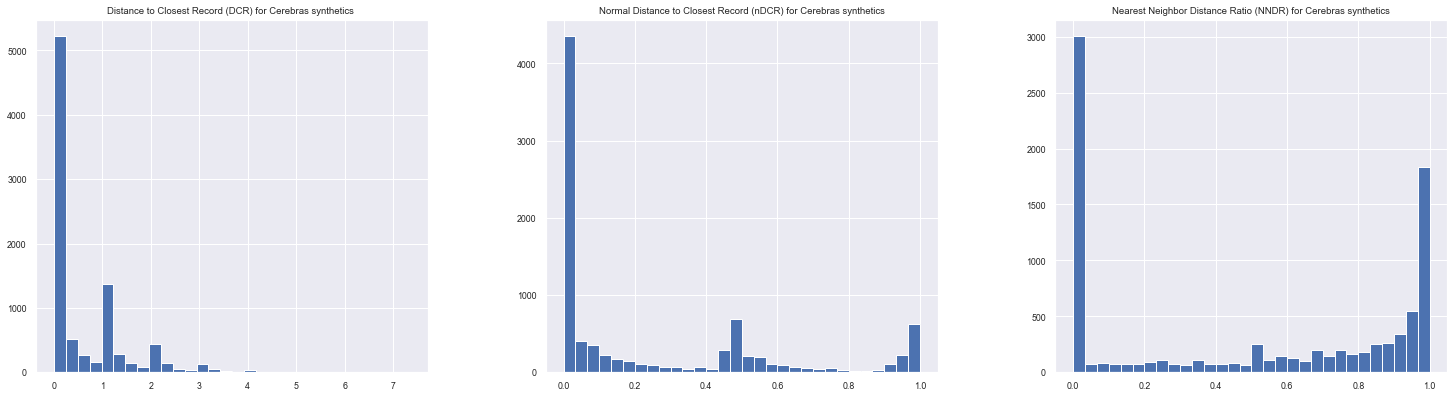

In [305]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

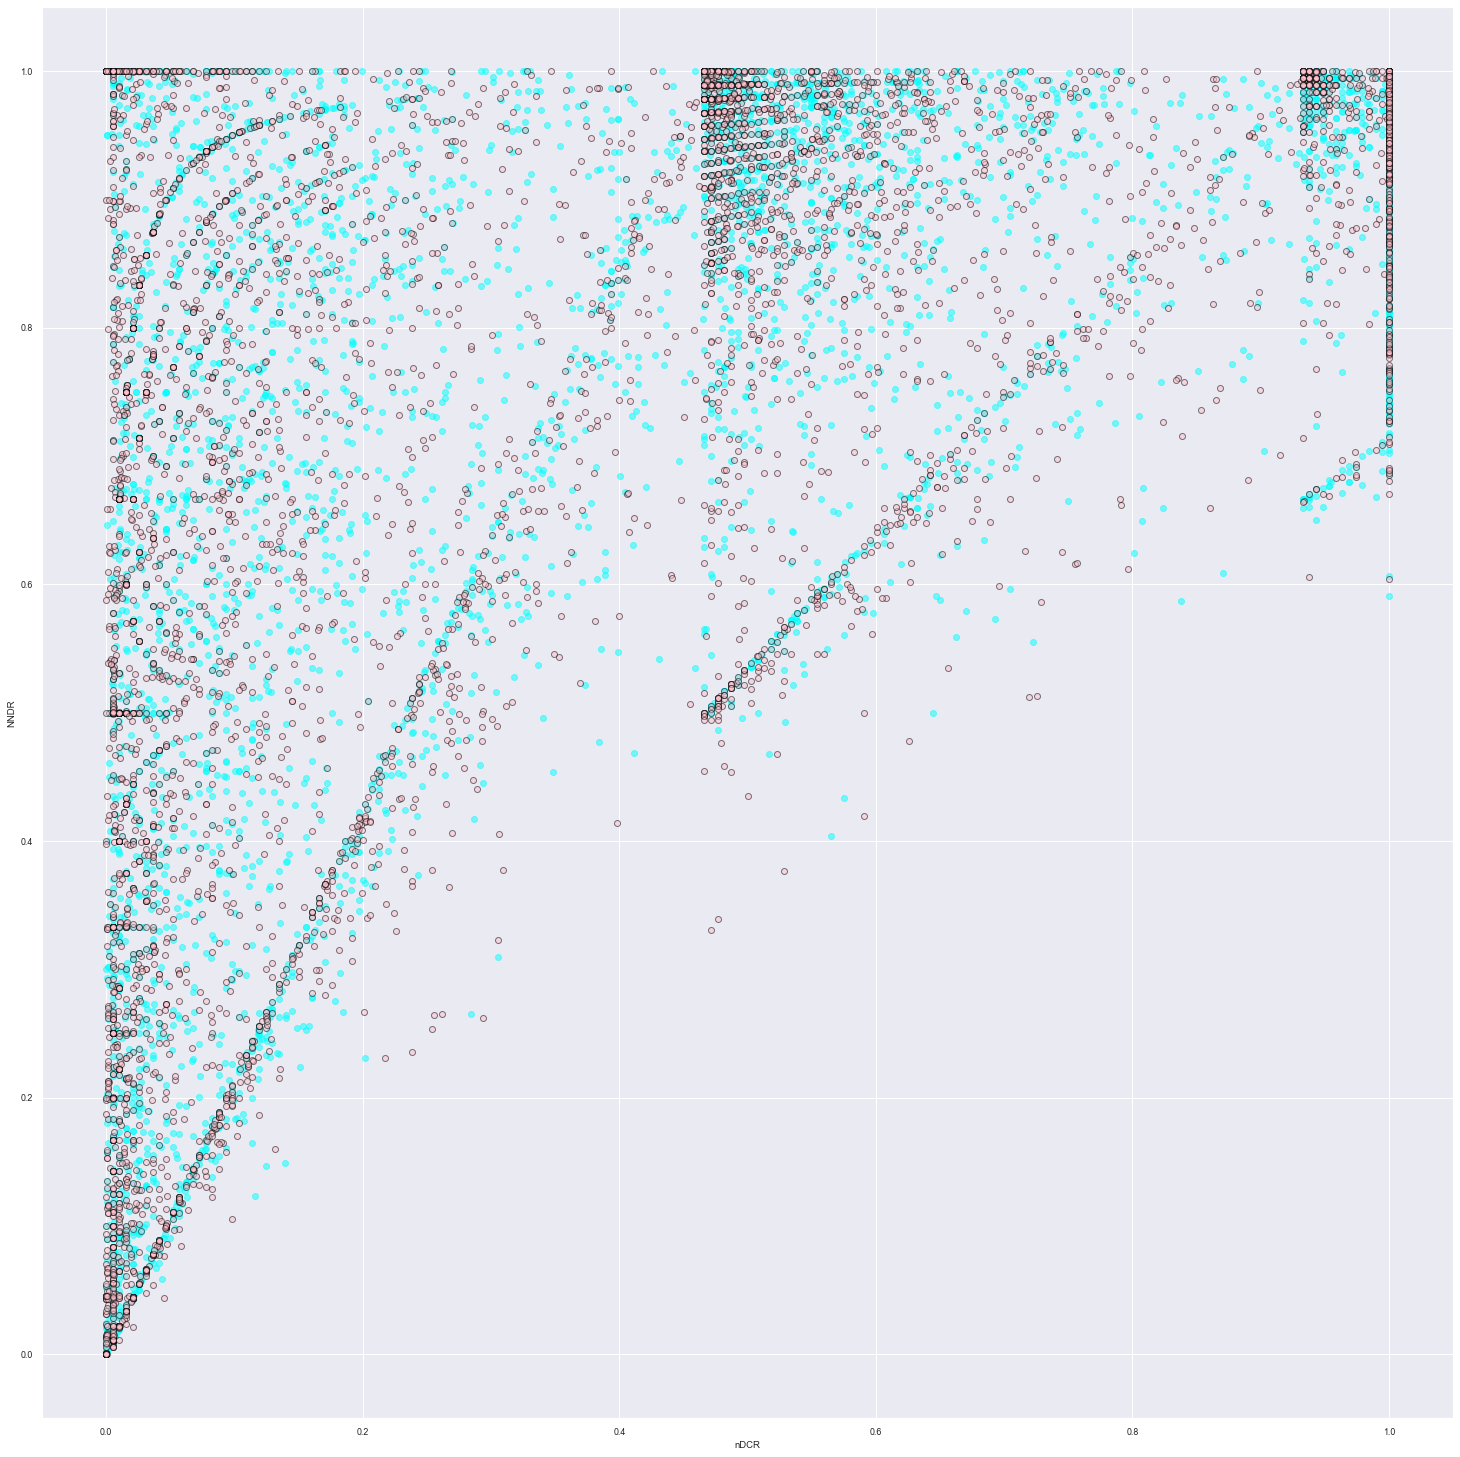

In [306]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [307]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

1.118145445987291

In [308]:
calc_nndr_ratio(nndr_real,nndr_synt3)

1.0910780669144982

In [309]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=39421381.50000000, p-value=0.00164113
 Mann-Whitney U rank test for NNDR: statistic=39496145.500000, p-value=0.003387


 Kolmogorov-Smirnov Test for nDCR: statistic=0.03211111, p-value=0.00018632
 Kolmogorov-Smirnov Test for NNDR: statistic=0.034333, p-value=0.000049


In [310]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [311]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [312]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [313]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [314]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [315]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.5003821097363621 0.41946076529944804 1.0 0.0 9000
nDCR stats 0.2533506227927963 0.331596782293058 1.0 0.0 9000
DCR Bound 0.95 % = 2.2531196581196564


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

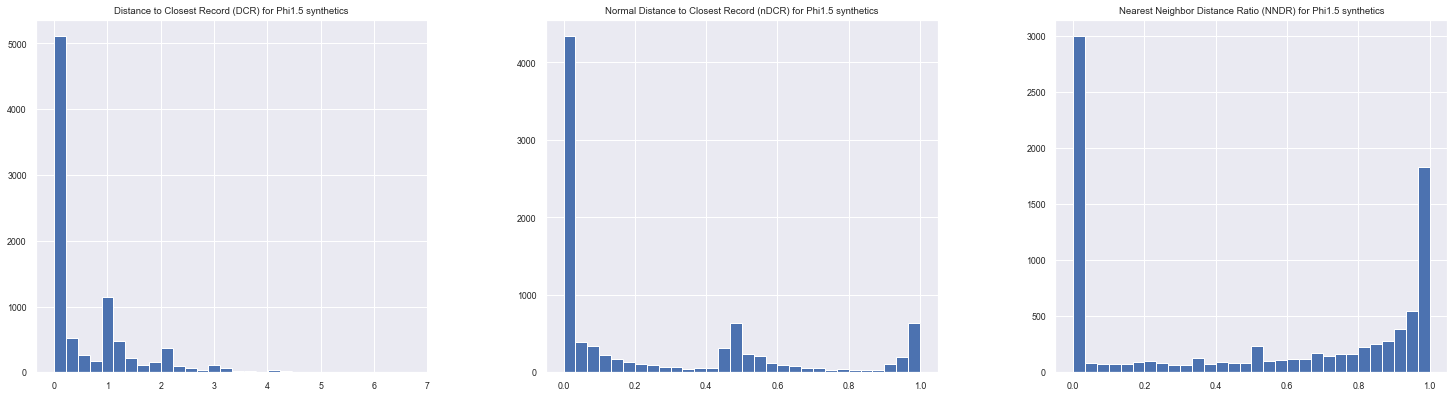

In [316]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

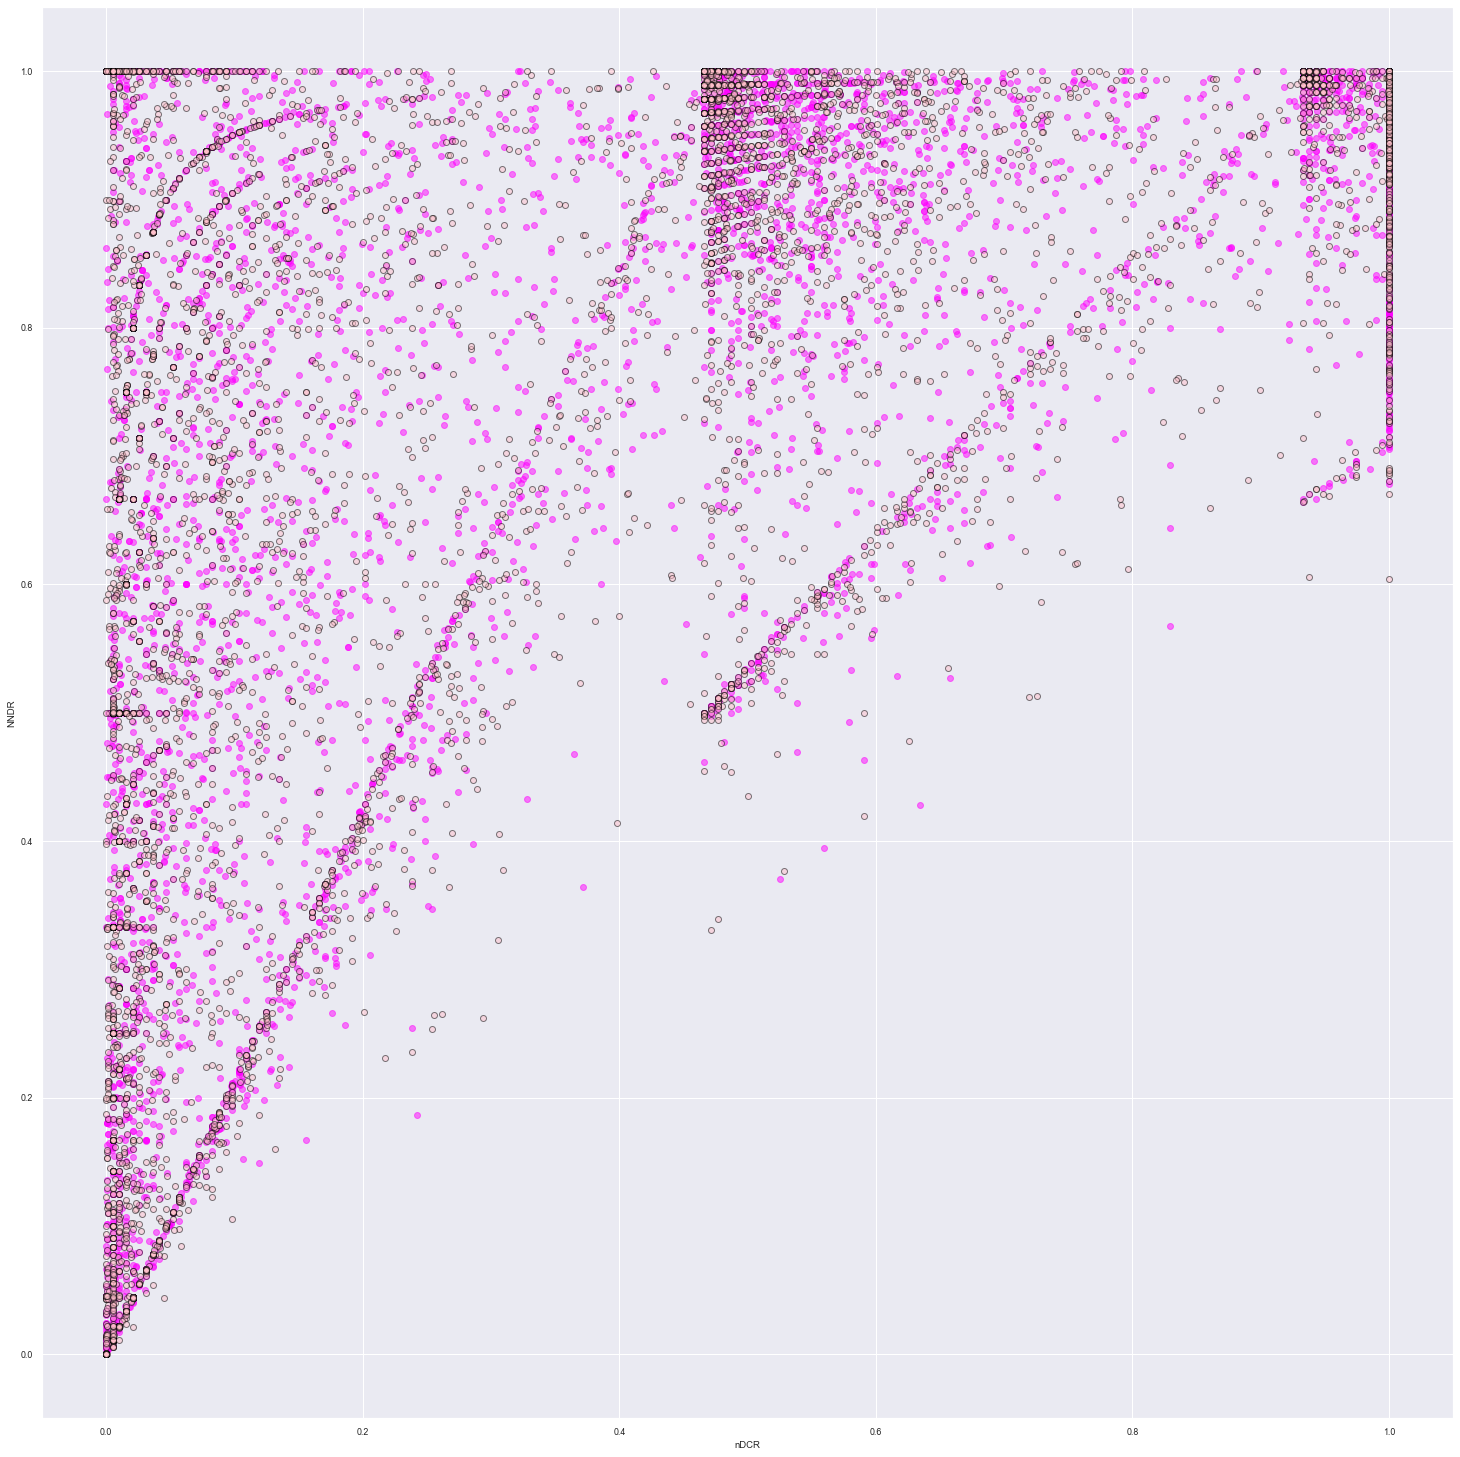

In [317]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [318]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

1.129673450070989

In [319]:
calc_nndr_ratio(nndr_real,nndr_synt4)

1.0886516593177071

In [320]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=39255539.00000000, p-value=0.00028085
 Mann-Whitney U rank test for NNDR: statistic=39371938.500000, p-value=0.000993


 Kolmogorov-Smirnov Test for nDCR: statistic=0.03566667, p-value=0.00002128
 Kolmogorov-Smirnov Test for NNDR: statistic=0.038111, p-value=0.000004


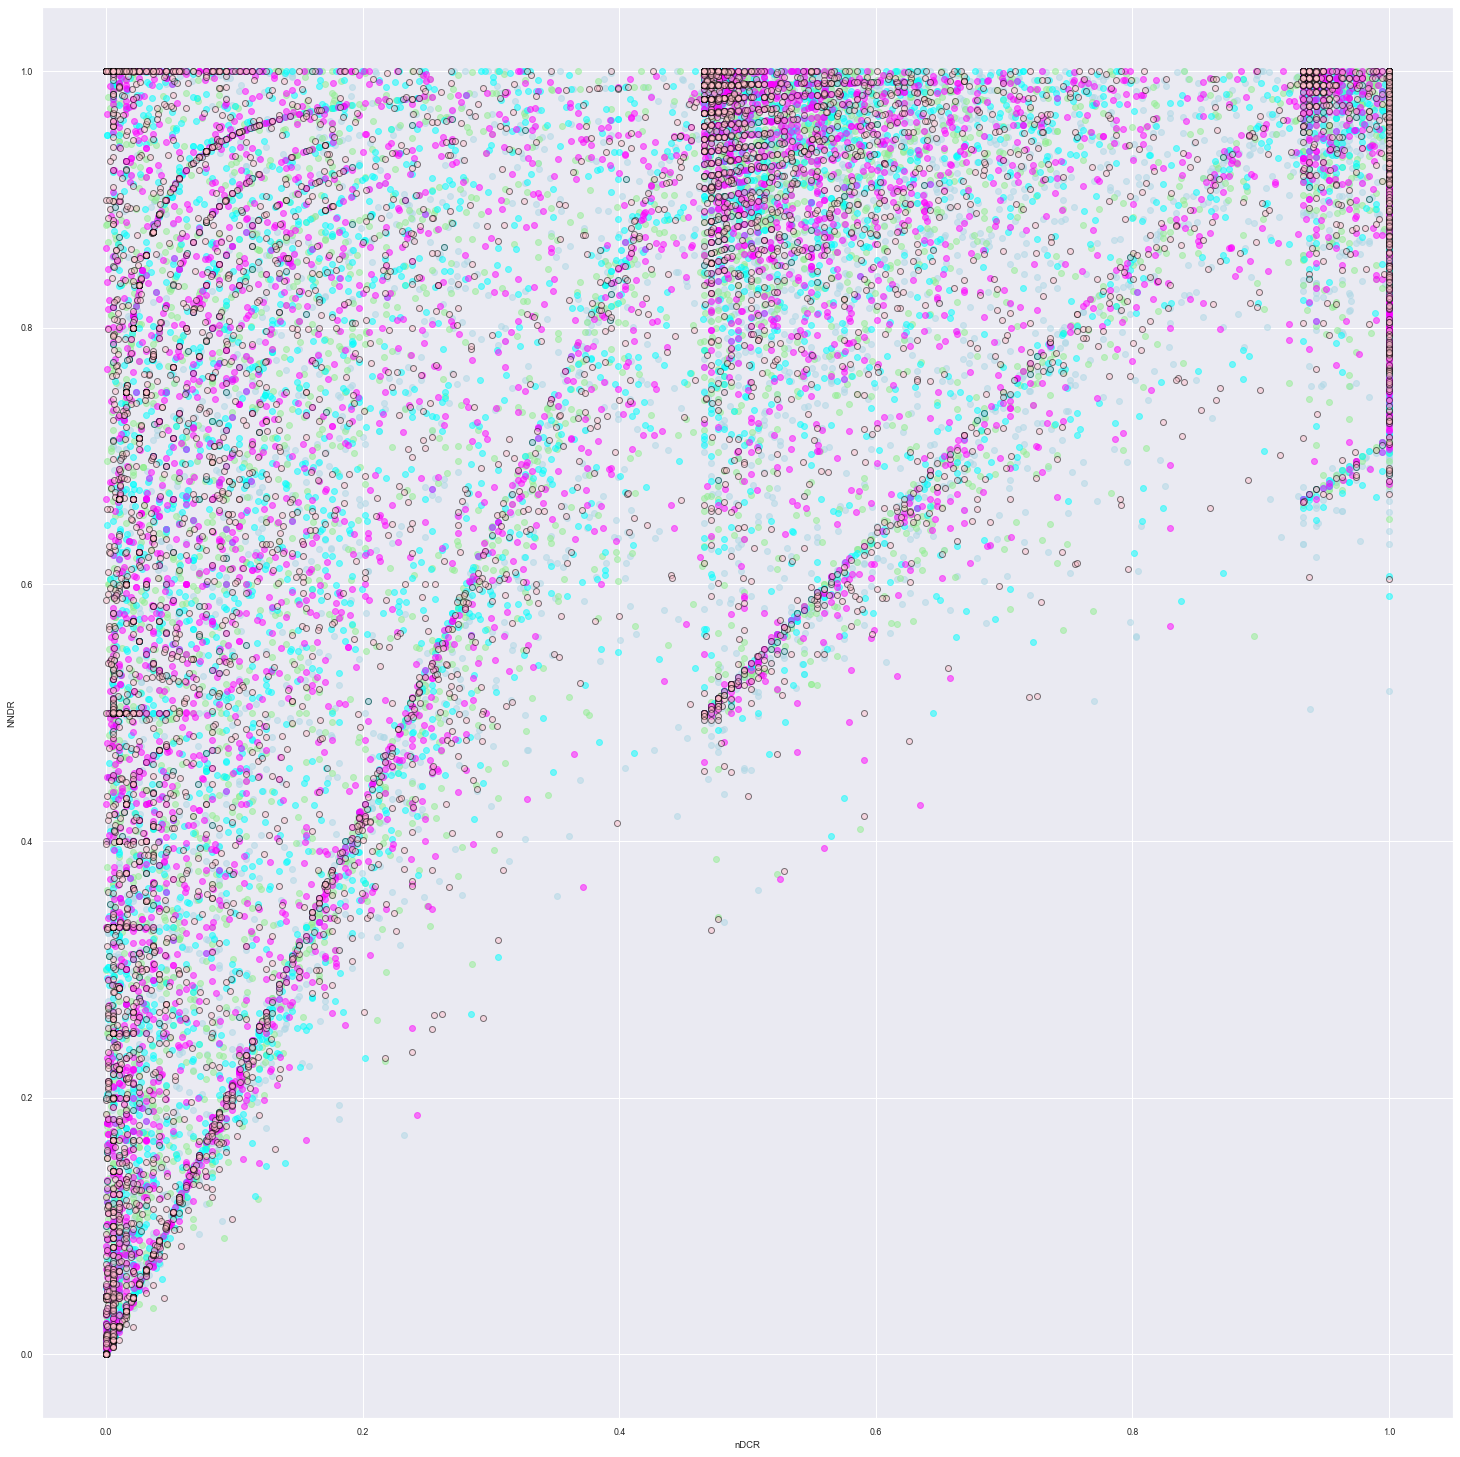

In [321]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [322]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [323]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   3.061968    2.492433    2.170130     0.466321     0.845474   
0        GPT2xl   2.316081    1.144900    1.100350     0.046632     0.571825   
0      Cerebras   2.259124    1.118145    1.091078     0.041451     0.567510   
0        Phi1.5   2.253120    1.129673    1.088652     0.043521     0.569607   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [324]:
privacy_results.to_csv('privacy_results_shortincome_temp1.0.csv')